# Citibike Case Analysis: Vinit Shah, Analytics Consultant

### Background, Context, and Objective
**Client:** Mayor of New York City, Bill de Blasio<br />
**Objective:** Help the mayor get a better understanding of citibike ridership by creating an operating report for 2017.

**Ask:** <br />
    1. Top 5 stations with the most starts (showing # of starts)
    2. Trip duration by user type
    3. Most popular trips based on start station and stop station)
    4. Rider performance by Gender and Age based on avg trip distance (station to station), 
       median speed (trip duration / distance traveled)
    5. What is the busiest bike in NYC in 2017? How many times was it used? How many minutes was it in use?
    6. A model that can predict how long a trip will take given a starting point and destination. 

First, let's minimize the work and load in the data set. Aggregate all the months and save the data as a csv to not require this to be done in the future.

The column names have spaces in them, would be great to remove them for working purposes. However, not necessary. If I was working on a team or a long term project, I would ocnfigure column names a little bit differently to make them easier to work with.
    
The dataset is massive, ~16mil rows. BigData tools would be helpful, however, most require you to pay or have an enterprise license or a limited trial. Additionally, the data is very dirty. Different files have different column names, need to account for this. Mayor de Blasio doesn't have a technical background. The graphs here are as simple yet informative as possible. I could've made more complicated plots, however, they would not be as informative for the mayor.

- Lastly, my analysis tries best to follow the crisp-dm methodology outlined below. 

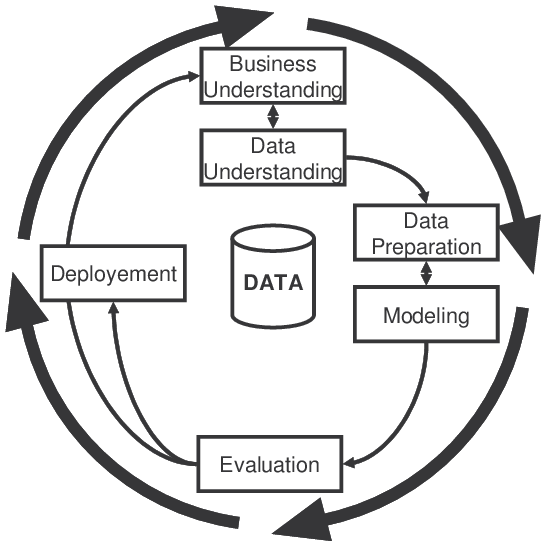

In [1]:
###################### Load Libraries and Data ######################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import *
import seaborn as sns
from matplotlib import rcParams
import datetime as dt
import math
import pickle

### Part 1: Top 5 Stations 
Let's check if there's any noise or cleanup which needs to be done before creating the chart. <br />
1. Any missing values?<br />
    - Mostly for Birth year and a few for User Type. We can ignore these for now and deal with them later.<br />
2. Let's get the data in the right format<br />
    - Trip Duration - Int<br />
    - Start Time - DateTime<br />
    - Stop Time - DateTime<br />
    - Start Station ID - Categorical<br />
    - Start Station Name - Categorical<br />
    - User Type - Categorical<br />
    - Birth Year - Ordinal<br />
    - Gender - Categorical<br />
3. Deal with trips which lasted less than 1.5 minute (90 seconds). If so, in the ideal world, we should not include this start, we may double count. If a bike is broken, a user will dock it again within a minute or two and pick-up another one.<br />
   - Would be ideal to not include any starts where a tip lasted less than 90 seconds *and* the start station = end station.<br /> 
4. Anomalies such as theft and broken docks shouldn't matter for this metric and can be dealth with later.

*The following code was used to load the Citibike data in one go. If you plan to use the same code, please make sure the only csv files in the working directory are the relevant citibike data files.*

In [2]:
#Set working directory to correct folder, or add path
#Minimize work to load data. Can be done in other ways as well. There may be a more effecient way to do this. Haven't explored this too deeply. 


#****************************************************************************************
#Download the files
#Comment these after the first run 
# !curl -O "https://s3.amazonaws.com/tripdata/2017[01-12]-citibike-tripdata.csv.zip"
# !unzip '*.zip'
# !rm *.zip
#****************************************************************************************
# files = !ls *.csv #For Ipython only
# df = pd.concat([pd.read_csv(f, header=None, skiprows=1,low_memory=False) for f in files], keys=None) 
# print(files)
#****************************************************************************************

#Let's see what we're working with


In [3]:
df= pd.read_csv("Files/NYC-BikeShare-2015-2017-combined.csv")
#df=df_


In [4]:
#df.reset_index(drop=True)
df.head()

,Unnamed: 0,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Trip_Duration_in_min
0,0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,Christ Hospital,40.734786,-74.050444,3207,Oakland Ave,40.737604,-74.052478,24470,Subscriber,1960.0,1,6
1,1,739,2015-10-01 00:27:12,2015-10-01 00:39:32,3207,Oakland Ave,40.737604,-74.052478,3212,Christ Hospital,40.734786,-74.050444,24481,Subscriber,1960.0,1,12
2,2,2714,2015-10-01 00:32:46,2015-10-01 01:18:01,3193,Lincoln Park,40.724605,-74.078406,3193,Lincoln Park,40.724605,-74.078406,24628,Subscriber,1983.0,1,45
3,3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,Newport Pkwy,40.728745,-74.032108,3187,Warren St,40.721124,-74.038051,24613,Subscriber,1975.0,1,5
4,4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,-74.055701,24668,Customer,1984.0,0,9


In [5]:
df.describe()
#df.describe(include = all)
#df.dtypes
#Scrappy way to get column names in the header.
# df2 = pd.read_csv('Files/NYC-BikeShare-2015-2017-combined.csv')
# df.columns = df2.columns[1:16]
# del[df2]

,Unnamed: 0,Trip Duration,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,Birth Year,Gender,Trip_Duration_in_min
count,735502.000000,7.355020e+05,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000
mean,10582.401084,9.343125e+02,3206.764183,40.723125,-74.046412,3203.387325,40.722371,-74.045415,24914.009133,1979.544239,1.123668,15.570669
std,7679.871929,4.063878e+04,26.546683,0.008121,0.011191,64.358120,0.095296,0.173044,753.768581,9.371192,0.519694,677.312437
min,0.000000,6.100000e+01,3183.000000,40.692640,-74.096937,147.000000,0.000000,-74.096937,14552.000000,1900.000000,0.000000,1.000000
25%,4484.000000,2.460000e+02,3186.000000,40.717732,-74.050656,3186.000000,40.716540,-74.050444,24486.000000,1975.000000,1.000000,4.000000
50%,9156.000000,3.830000e+02,3202.000000,40.721525,-74.044247,3199.000000,40.721124,-74.043845,24602.000000,1982.000000,1.000000,6.000000
75%,15003.000000,6.520000e+02,3211.000000,40.727596,-74.038051,3211.000000,40.727224,-74.036486,24711.000000,1986.000000,1.000000,11.000000
max,34148.000000,2.026021e+07,3426.000000,40.752559,-74.032108,3442.000000,40.801343,0.000000,29296.000000,2000.000000,2.000000,337670.000000


In [6]:
###################### Code above only needs to be run once ######################
#Load aggregated dataset to minimize time needed to run the code
df = df.drop(['Unnamed: 0'], axis = 1)
print(df.columns)
df_copy = df
df.head()

Index(['Trip Duration', 'Start Time', 'Stop Time', 'Start Station ID',
       'Start Station Name', 'Start Station Latitude',
       'Start Station Longitude', 'End Station ID', 'End Station Name',
       'End Station Latitude', 'End Station Longitude', 'Bike ID', 'User Type',
       'Birth Year', 'Gender', 'Trip_Duration_in_min'],
      dtype='object')


,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Trip_Duration_in_min
0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,Christ Hospital,40.734786,-74.050444,3207,Oakland Ave,40.737604,-74.052478,24470,Subscriber,1960.0,1,6
1,739,2015-10-01 00:27:12,2015-10-01 00:39:32,3207,Oakland Ave,40.737604,-74.052478,3212,Christ Hospital,40.734786,-74.050444,24481,Subscriber,1960.0,1,12
2,2714,2015-10-01 00:32:46,2015-10-01 01:18:01,3193,Lincoln Park,40.724605,-74.078406,3193,Lincoln Park,40.724605,-74.078406,24628,Subscriber,1983.0,1,45
3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,Newport Pkwy,40.728745,-74.032108,3187,Warren St,40.721124,-74.038051,24613,Subscriber,1975.0,1,5
4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,-74.055701,24668,Customer,1984.0,0,9


In [7]:
#Percentage of missing data.
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data(df)

,Total,Percent
Trip_Duration_in_min,0,0.0
Gender,0,0.0
Birth Year,0,0.0
User Type,0,0.0
Bike ID,0,0.0
End Station Longitude,0,0.0
End Station Latitude,0,0.0
End Station Name,0,0.0
End Station ID,0,0.0
Start Station Longitude,0,0.0


In [8]:
#Ensure data is formatted correctly to avoid errors in the visuals
df['Start Time'] = to_datetime(df['Start Time'])
df['Stop Time'] = to_datetime(df['Stop Time'])
df['Start Station Name'] = df['Start Station Name'].astype('category')
df['End Station Name'] = df['End Station Name'].astype('category')
df['User Type'] = df['User Type'].astype('category')
df['Gender'] = df['Gender'].astype('category')
round(df.describe(),2)

,Trip Duration,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,Birth Year,Trip_Duration_in_min
count,735502.00,735502.00,735502.00,735502.00,735502.00,735502.00,735502.00,735502.00,735502.00,735502.00
mean,934.31,3206.76,40.72,-74.05,3203.39,40.72,-74.05,24914.01,1979.54,15.57
std,40638.78,26.55,0.01,0.01,64.36,0.10,0.17,753.77,9.37,677.31
min,61.00,3183.00,40.69,-74.10,147.00,0.00,-74.10,14552.00,1900.00,1.00
25%,246.00,3186.00,40.72,-74.05,3186.00,40.72,-74.05,24486.00,1975.00,4.00
50%,383.00,3202.00,40.72,-74.04,3199.00,40.72,-74.04,24602.00,1982.00,6.00
75%,652.00,3211.00,40.73,-74.04,3211.00,40.73,-74.04,24711.00,1986.00,11.00
max,20260211.00,3426.00,40.75,-74.03,3442.00,40.80,0.00,29296.00,2000.00,337670.00


In [9]:
#Quasi Confirm Hypothesis in point #3
df_bikenum = pd.DataFrame()
df_bikenum['First Bike'] = df[df['Trip Duration'] < 90]['Start Station Name'] 
df_bikenum['Second Bike'] = df[df['Trip Duration'] < 90]['End Station Name']
#df_bikenum.head()

In [10]:
#Clear up enviornment and drop double count
del(df_bikenum)
df = df.drop(df.index[(df['Trip Duration'] < 90) & 
                          (df['Start Station Latitude'] == df['End Station Latitude'])])

In [11]:
#Data for Top 5 Stations visual
top5 = pd.DataFrame() 
top5['Station']=df['Start Station Name'].value_counts().head().index
top5['Number of Starts']=df['Start Station Name'].value_counts().head().values
top5['Station'] = top5['Station'].cat.remove_unused_categories()
top5['Station'] = top5['Station'].astype('object')
#top5.sort_values(by = 'Number of Starts', ascending = False)

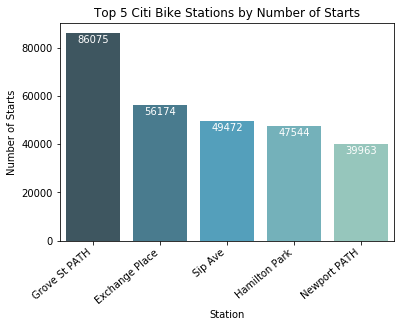

In [12]:
#Plot for Part 1: Top 5 Stations
ax = sns.barplot('Station', 'Number of Starts', data = top5, palette="GnBu_d")
ax.set_title('Top 5 Citi Bike Stations by Number of Starts', fontsize = 12)
rcParams['figure.figsize'] = 12,7
ax.set_xticklabels(ax.get_xticklabels(),rotation=40, ha = 'right')
for index, row in top5.iterrows():
    ax.text(index,row['Number of Starts']-4000,row['Number of Starts'], 
            color='white', ha="center", fontsize = 10)
plt.show()

### Part 2: Trip Duration by User Type
This question is a bit unclear in terms of what to do with the anomalies, so I'll be making two graphs. One with anomalies, one without.<br />

*There are NA values in the dataset for usertype as can be seen from missing_table. Since it's only 0.09% of the data, it's safe to remove.*<br />

**According to Citi Bikes' website:** The first 45 minutes of each ride is included for Annual Members, and the first 30 minutes of each ride is included for Day Pass users. If you want to keep a bike out for longer, it’s only an extra $4 for each additional 15 minutes.<br />

It's safe to assume, no one (or very few people) will be willing to rent a bike for more than 2 hours, especially a clunky citibike. If they did, it would cost them an additional $20 assuming they're annual subscribers. It would be more economical for them to buy a bike if they want that workout or use one of the tour bikes in central park if they want to tour and explore the city on a bike. There may be a better way to choose an optimal cutoff, however, time is key in a client project. Or just docing and getting another bike. The real cost of a bike is accrued ~24 hours. <br />

**Anomalies**: Any trip which lasts longer than 2 hours (7,200 seconds) probably indicates a stolen bike, an anomaly, or incorrect docking of the bike. As an avid Citibike user, I know first hand that it doesn't make any sense for one to use a bike for more than one hour! However, I've added a one hour cushion just in case. No rider would plan to go over the maximum 45 minutes allowed. However, I wplan to reduce this to one hour in the future for modelling purposes. 

1. *First Half- with anomalies in dataset*
    - The graph under ax2 is a bargraph of average trip duration for each user type. It's helpful, but would be better to see a boxplot and get an idea of the distribution and see mintues instead of seconds.<br />
    - Second graph is a basic Boxplot based with anomalies included. As we can see, there is too much noise for this to be useful. It'll be better to look at this without anomalies.<br />

2. *Second Half - without anomalies in dataset*
    - Still not useful, let's add a column with minutes for trip Duration.<br />
    - Boxplot with minutes is much more useful. There are still some outliers, however, it is informative. 

In [13]:
del(top5)
#Drop NA Usertype
df = df.dropna(subset=['User Type']) 

In [14]:
#Calculate trip duration
TD_user = pd.DataFrame()
TD_user['Avg. Trip Duration'] = round(df.groupby('User Type')['Trip Duration'].mean(),2)
TD_user = TD_user.reset_index()
TD_user['User Type'] = TD_user['User Type'].astype('object')

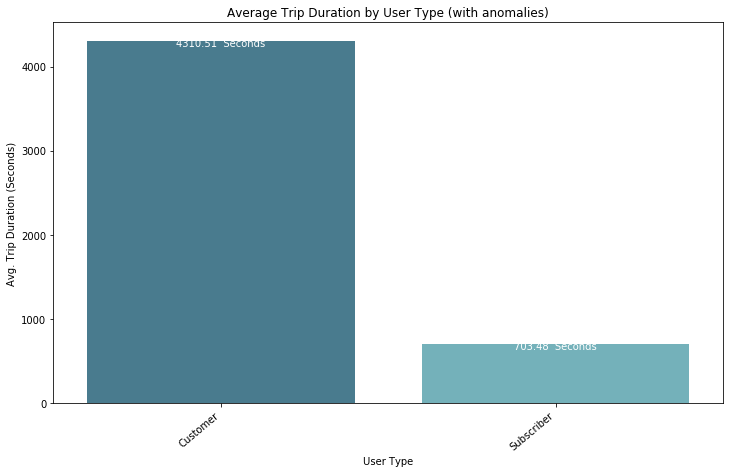

In [15]:
#Average trip Duration per User Type with Anomalies
ax2 = sns.barplot('User Type', 'Avg. Trip Duration', data = TD_user,palette="GnBu_d")
ax2.set_title('Average Trip Duration by User Type (with anomalies)')
#rcParams['figure.figsize'] = 12,7
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=40, ha = 'right')
ax2.set_ylabel('Avg. Trip Duration (Seconds)')
for index, row in TD_user.iterrows():
    ax2.text(index,row['Avg. Trip Duration']-70,(str(row['Avg. Trip Duration'])+"  Seconds"), 
             color='white', ha="center", fontsize = 10)
plt.show()

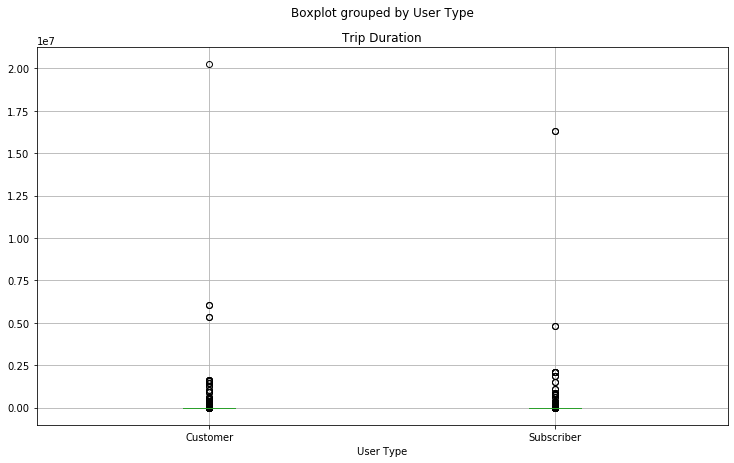

In [16]:
#Boxplots are more informative to visualize breakdown of data
del(TD_user)
df.boxplot('Trip Duration', by = 'User Type')
plt.show()

In [17]:
#Remove anomalies based on definition above
df = df.drop(df.index[(df['Trip Duration'] > 7200)])

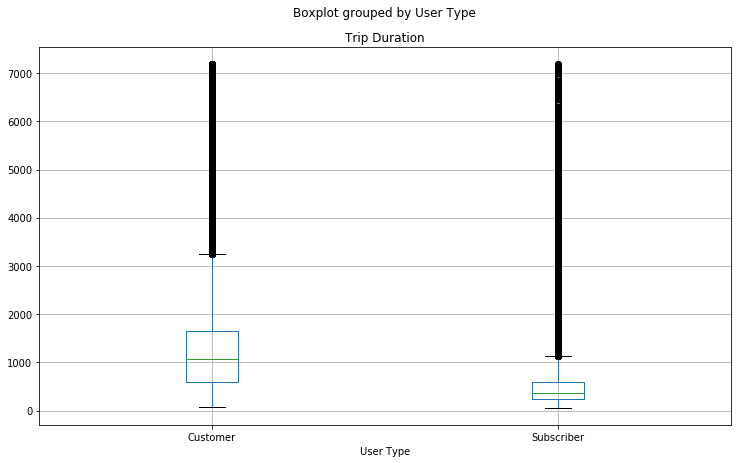

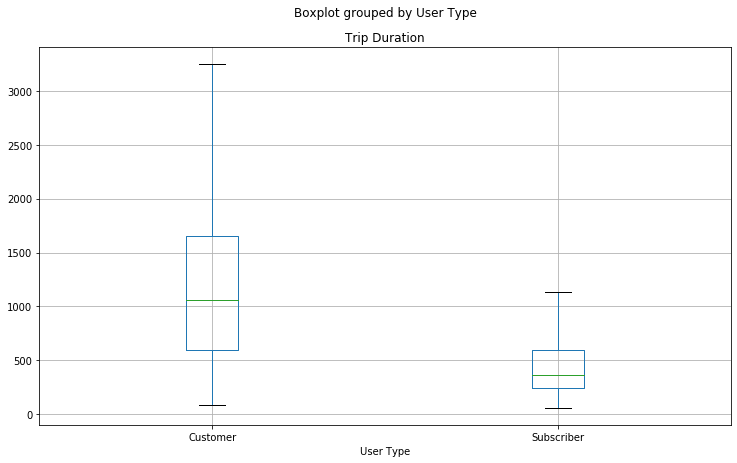

In [18]:
#Boxplots are more informative to visualize breakdown of data
df.boxplot('Trip Duration', by = 'User Type')
plt.show()
#Boxplot without outliers
df.boxplot('Trip Duration', by = 'User Type',showfliers=False)
plt.show()

In [19]:
#Add Minutes column for Trip Duration
df['Minutes'] = df['Trip Duration']/60
#For Visual purposes, rounded
df['Minutes'] = round(df['Minutes'])
df['Minutes'] = df['Minutes'].astype(int)

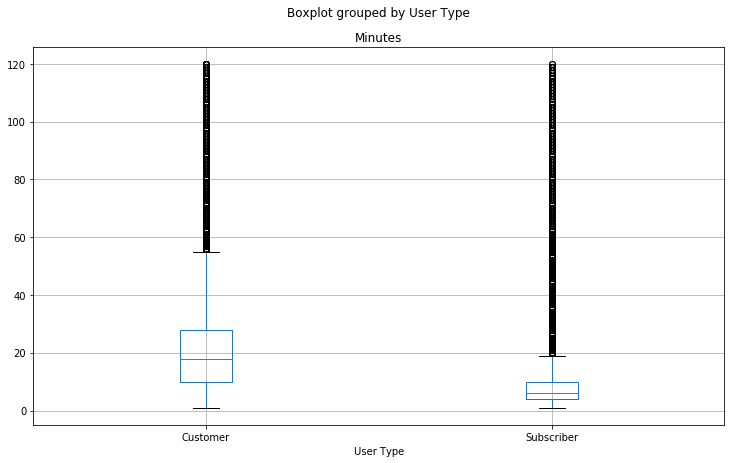

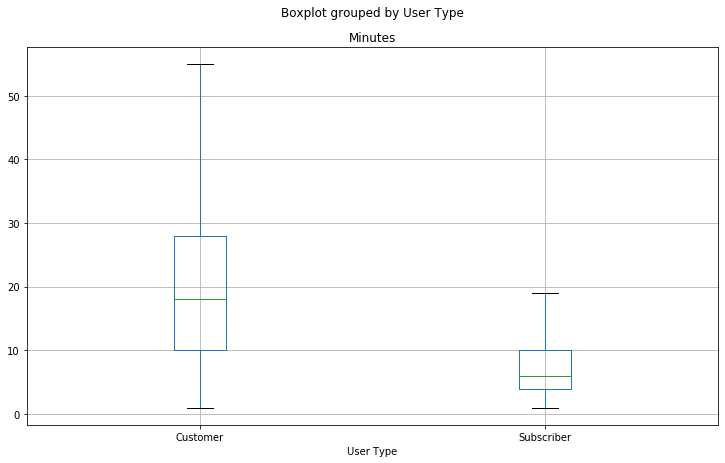

In [20]:
#Final Boxplot with some outliers. Could turn of outliers with showfliers = False
df.boxplot('Minutes', by = 'User Type')
plt.show()
df.boxplot('Minutes', by = 'User Type', showfliers = False)
plt.show()

In [21]:
TD_user2 = pd.DataFrame()
TD_user2['Avg. Trip Duration'] = round(df.groupby('User Type')['Minutes'].mean(),1)
TD_user2 = TD_user2.reset_index()
TD_user2['User Type'] = TD_user2['User Type'].astype('object')

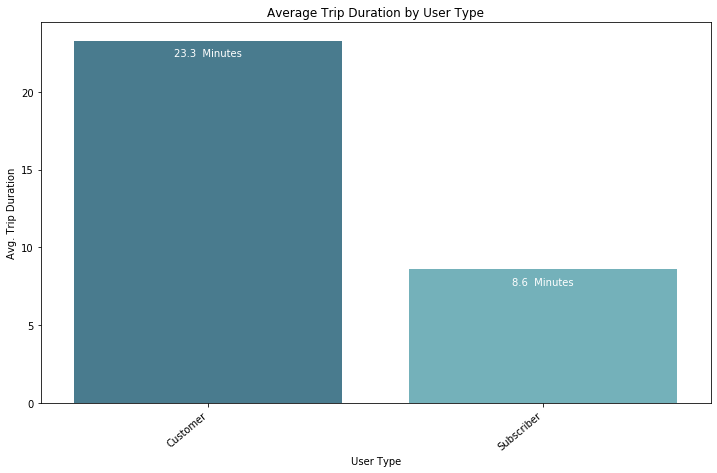

In [22]:
#Average Trip Duration Based on Minutes
ax3 = sns.barplot('User Type', 'Avg. Trip Duration', data = TD_user2,palette="GnBu_d")
ax3.set_title('Average Trip Duration by User Type')
#rcParams['figure.figsize'] = 12,10
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=40, ha = 'right')
for index, row in TD_user2.iterrows():
    ax3.text(row.name,row['Avg. Trip Duration']-1,(str(row['Avg. Trip Duration'])+"  Minutes"), 
             color='white', ha="center", fontsize = 10)
plt.show()

In [23]:
del(TD_user2)
#Undo rounding for modelling purposes
df['Minutes'] = df['Trip Duration']/60

### Part 3: Most Popular Trip
To get most popular trips, the most convenient way to do this is by using the groupby function in pandas. It's analogous to a Pivot table. <br />

The groupby function makes it extremely easy and convenient to identify the most popular trips. Visuals and transformations can be found below.<br />

In [24]:
#Identify the 10 most popular trips
trips_df = pd.DataFrame()
trips_df = df.groupby(['Start Station Name','End Station Name']).size().reset_index(name = 'Number of Trips')
trips_df = trips_df.sort_values('Number of Trips', ascending = False)
trips_df["Start Station Name"] = trips_df["Start Station Name"].astype(str)
trips_df["End Station Name"] = trips_df["End Station Name"].astype(str)
trips_df["Trip"] = trips_df["Start Station Name"] + " to " + trips_df["End Station Name"]
trips_df = trips_df[:10]
trips_df = trips_df.drop(['Start Station Name', "End Station Name"], axis = 1)
trips_df = trips_df.reset_index()
#trips_df.head()

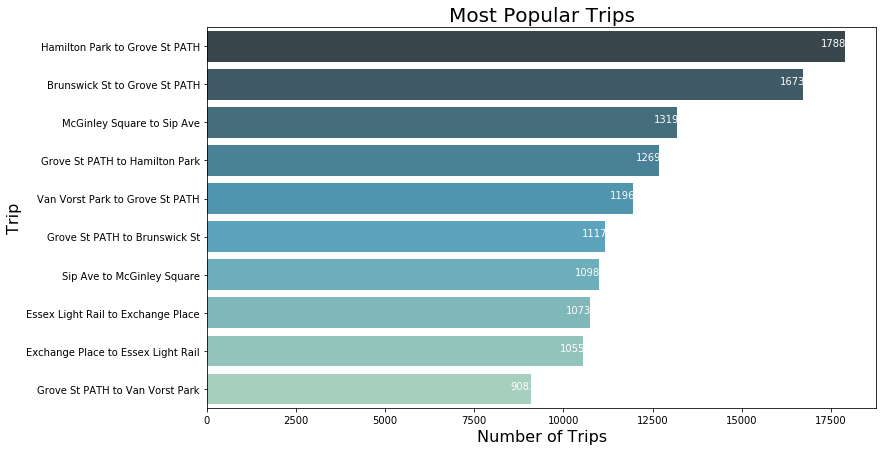

In [25]:
ax4 = sns.barplot('Number of Trips','Trip', data = trips_df,palette="GnBu_d")
ax4.set_title('Most Popular Trips', fontsize = 20)
ax4.set_ylabel("Trip",fontsize=16)
ax4.set_xlabel("Number of Trips",fontsize=16)
for index, row in trips_df.iterrows():
    ax4.text(row['Number of Trips']-220,index,row['Number of Trips'], 
             color='white', ha="center",fontsize = 10)
plt.show()

### Part 4: Rider Performance by Gender and Age

**Ask:** Rider performance by Gender and Age based on avg trip distance (station to station), median speed (trip duration/distance traveled)<br />

Let's make sure the data we're working with here is clean.<br />

1. Missing Gender and Birth Year values - Check missing_table above
    - No for Gender. Yes for Birth Year
    - ~10% Missing Birth year. Not a big chunk of data. Can either impute missing values or drop it. Since it's less                                         than 10% of the data, it's safe to assume the rest of the 90% is a representative sample of data and we can replace the birth year with the median, based on gender and Start Station ID. I chose this method because most people the same age live in similar neighborhoods (i.e: young people in east village, older people in Upper West Side, etc.). This will be done after anomalies are removed and speed is calculated.
2. Are there anomalies?
    - For Birth Year, there are some people born prior to 1956. I can believe some 60 year olds can ride a bike and that's a stretch, however, anyone "born" prior to that riding a citibike is an anomaly and false data. There could be a few senior citizens riding a bike, but probably not likely.
    - My approach is to identify the age 2 standard deviations lower than the mean. After calculating this number, mean-2stdev, I removed the tail end of the data, birth year prior to 1956.
3. Caulculate an Age column to make visuals easier to interpret.
4. Calculate trip distance (Miles)
    - No reliable way to calculate bike route since we can't know what route a rider took without GPS data from each bike. 
    - Could use Google maps and use lat,long coordinates to find bike route distance. However, this would require more than the daily limit on API calls. Use the geopy.distance packge which uses Vincenty distance uses more accurate ellipsoidal models. This is more accurate than Haversine formula, but doesn't matter much for our purposes.
5. Caulculate Speed (min/mile) and (mile/hr)
    - (min/mile): Can be used like sprint time (how fast does this person run)
    - (mile/hr): Conventional approach. Miles/hour is an easy to understand unit of measure and one most people are used to seeing. So the visual will be created based on this understanding.
6. Dealing with "circular" trips
    - Circular trips are trips which start and end at the same station. The distance for these trips will come out to 0, however, that is not the case. These points will skew the data and visuals. Will be removing them to account for this issue. 
    - For the model, this data is also irrelevant. Because if someone is going on a circular trip, the only person who knows how long the trip is going to take is therider themself, assuming they know that. So it's safe to drop this data for the model. <br />
7. Rename Gender Values in Legend from 0,1,2 to Unknown, Male, Female, respectively. 
    - The rows where Gender is unknown throws the visual off. There are a few ways to handle this: 
      - Remove the missing data. This would not result in a significant loss of information since only 58073 rows have gender as unknown.
       - We can impute missing values, however given the proportion of unknowns the information gain would be negligible.
       - Based on the reasons above, I've decided to remove data with unknown gender. These rows should not have a  significant imact on the predictive model later on. However, I will confirm this.
8. Determine Gender and Age performance based on Average Trip distance<br />
    - Similar to graphs for speed. Pretty straightforward.

In [26]:
del(trips_df)
#Drop the tail end of birth years 2 standard deviations below the mean
#df['Birth Year'].mean()-(2*df['Birth Year'].std())

df = df.drop(df.index[(df['Birth Year'] < 1956)])

In [27]:
#Combine coordinates to calculate distance based on Vincenty
df['Start Coordinates'] = list(zip(df['Start Station Latitude'], df['Start Station Longitude']))
df['End Coordinates'] = list(zip(df['End Station Latitude'], df['End Station Longitude']))

In [28]:
# In the future, for a dataset of this size, I would consider using the Haversine formula to calculate distance 
# # if it's faster.
# import geopy.distance
# dist = []
# for i in range(len(df)):
#     dist.append(geopy.distance.distance(df.iloc[i]['Start Coordinates'],df.iloc[i]['End Coordinates']).miles)
#     if (i%1000000==0):
#         print(i)

#Code above takes a long time to run, please use Distance.csv file instead


In [29]:
# pickle_out = open("distance.pickle","wb")
# pickle.dump(dist, pickle_out)
# pickle_out.close()

In [30]:
pickle_in =  open("distance.pickle","rb")
dist=pickle.load(pickle_in)
df['Distance'] = dist

In [31]:
#Reset Index to avoid issues in future calculations
df = df.reset_index()
df = df.drop('index',axis =1)

In [32]:
del(dist)
#Replace missing birth year by median based on speed and gender
df['Birth Year'] = df.groupby(['Gender','Start Station ID'])['Birth Year'].transform(lambda x: x.fillna(x.median()))

In [33]:
#Still have a few nulls, but it's only 2342 entries now. Comfortable dropping these.
df = df.dropna(subset=['Birth Year'])

In [34]:
#Calculate age and drop circular/roundtrips
df['Age'] = 2018 - df['Birth Year']
df['Age'] = df['Age'].astype(int)

In [35]:
df = df.drop(df.index[(df['Distance'] == 0)])

In [36]:
#1
#df[df['Trip Duration']<90]
#2. Followed the same reasoning as behind Birth Year. People in similar locations tend to also work in a similar industry or location
df['Distance'] = df.groupby(['Gender','Start Station ID'])['Distance'].transform(lambda x: x.fillna(x.median()))

In [37]:
df['min_mile'] = round(df['Minutes']/df['Distance'], 2)
df['mile_hour'] = round(df['Distance']/(df['Minutes']/60),2)

In [38]:
#Let's check for data integrity to make sure all the numbers look as expected. Only numerical data included
round(df.describe(),2)

,Trip Duration,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,Birth Year,Trip_Duration_in_min,Minutes,Distance,Age,min_mile,mile_hour
count,682576.00,682576.00,682576.00,682576.00,682576.00,682576.00,682576.00,682576.00,682576.00,682576.00,682576.00,682576.00,682576.00,682576.00,682576.00
mean,512.73,3206.93,40.72,-74.05,3203.39,40.72,-74.05,24918.80,1980.02,8.54,8.55,0.69,37.98,14.06,5.80
std,491.07,26.80,0.01,0.01,64.33,0.01,0.01,757.05,8.67,8.19,8.18,0.45,8.67,21.43,2.00
min,61.00,3183.00,40.69,-74.10,152.00,40.69,-74.10,14552.00,1956.00,1.00,1.02,0.09,18.00,3.62,0.07
25%,242.00,3186.00,40.72,-74.05,3186.00,40.72,-74.05,24486.00,1976.00,4.00,4.03,0.40,32.00,8.48,4.64
50%,367.00,3202.00,40.72,-74.04,3198.00,40.72,-74.04,24603.00,1982.00,6.00,6.12,0.55,36.00,10.22,5.87
75%,601.00,3211.00,40.73,-74.04,3211.00,40.73,-74.04,24712.00,1986.00,10.00,10.02,0.88,42.00,12.93,7.08
max,7187.00,3426.00,40.75,-74.03,3426.00,40.78,-73.96,29296.00,2000.00,120.00,119.78,5.26,62.00,865.69,16.58


### Observations
- We still have trips less than 90 seconds, however they seem to be legitimate trips. Checked using the code in cell above. 
- We have some Start Coordinates as (0.0,0.0). These are trips which were taken away for repair or for other purposes. These should be dropped. If kept, the distance for these trips is 5,389 miles. For this reason I've dropped any points where the distance is greater than 30 miles. Additionally, we have some missing values. Since it's a tiny portion, let's replace missing values based on Gender and start location. These
- One some trips, the speed of the biker is more than 200 mph. This could be due to the formula used for distance calculation or some other error. The fastest cyclist in the world on a flat surface ever recorded biked at 82mph. It's safe to assume none of the citibike riders can approach this speed. Due to this and the fact that an average cyclist speed is 10mph, I've decided to remove all data where the speed in mph is greater than 20 mph and less than 0.1 mph. ~1.5k data points

In [39]:
df = df[df['Distance'] < 30]

In [40]:
#3.1-Done in two steps to ensure data integrity, could've used an or statement as well.
df = df[df['mile_hour']<20]
#3.2
df = df[df['mile_hour']> (df['mile_hour'].mean()-(2*df['mile_hour'].std()))]

In [41]:
#Dropping unknown to make the visual more informative. 
#Unknown gender may be important for the model, which is why I created a copy of the original dataframe.
df1 = df.drop(df.index[(df['Gender'] == 0)])

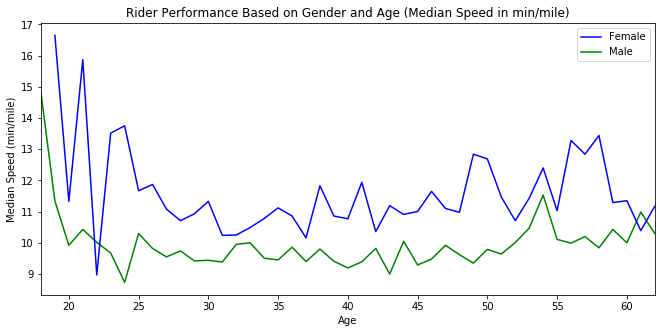

In [42]:
#Rider performance by age and Gender in Min/Mile 
fig, ax5 = plt.subplots(figsize=(11,5))
df1.groupby(['Age','Gender']).median()['min_mile'].unstack().plot(ax=ax5, color ="bg")
ax5.legend(['Female','Male'])
plt.ylabel('Median Speed (min/mile)')
plt.title('Rider Performance Based on Gender and Age (Median Speed in min/mile)')
plt.show()

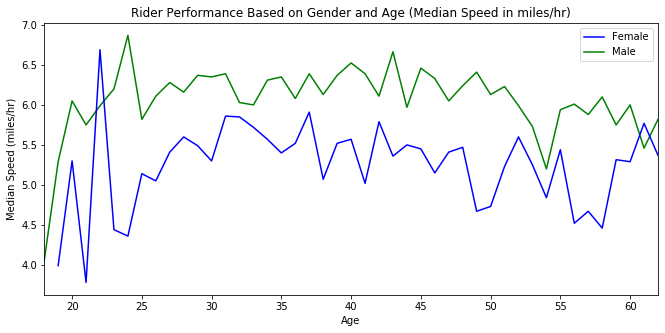

In [43]:
#Rider performance by age and Gender in Miles/hr
del([fig,ax5])
fig1, ax6 = plt.subplots(figsize=(11,5))
df1.groupby(['Age','Gender']).median()['mile_hour'].unstack().plot(ax=ax6,color ="bg")
ax6.legend(['Female', 'Male'])
plt.ylabel('Median Speed (miles/hr)')
plt.title('Rider Performance Based on Gender and Age (Median Speed in miles/hr)')
plt.show()

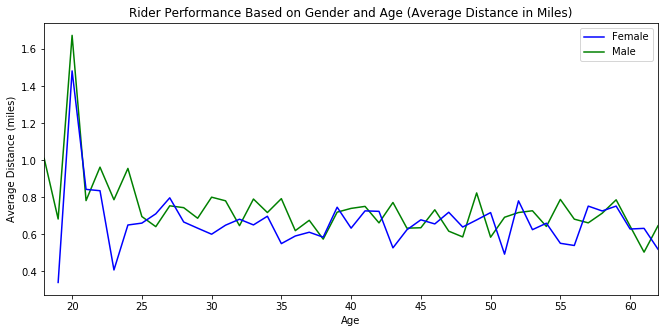

In [44]:
#Rider performance by age and Gender in Averge Distance
del([fig1,ax6])
fig2, ax7 = plt.subplots(figsize=(11,5))
df1.groupby(['Age','Gender']).mean()['Distance'].unstack().plot(ax=ax7,color ="bg")
ax7.legend(['Female', 'Male'])
plt.ylabel('Average Distance (miles)')
plt.title('Rider Performance Based on Gender and Age (Average Distance in Miles)')
plt.show()

### Part 5: Busiest Bike by Times and Minutes Used
*Ask:* 
 1. What is the busiest bike in NYC in 2017? 
    - Bike 25738
 2. How many times was it used?
     - 2355 times
 3. How many minutes was it in use?
      - 31,340 Minutes

- Busiest bike and count can be identified by a groupby function
- Function above will also identify the number of times the bike was used
- A similar groupby function which calls for the sum on minutes can identify the number of minutes the bike was used. 

In [45]:
#Bike usage based on number of times used
del(df1)
bike_use_df = pd.DataFrame()
bike_use_df = df.groupby(['Bike ID']).size().reset_index(name = 'Number of Times Used')
bike_use_df = bike_use_df.sort_values('Number of Times Used', ascending = False)
#bike_use_df.to_csv('Q5.csv')
bike_use_df = bike_use_df[:10]
bike_use_df['Bike ID'] = bike_use_df['Bike ID'].astype(str)
bike_use_df['Bike ID'] = ('Bike ' + bike_use_df['Bike ID'])
bike_use_df = bike_use_df.reset_index()
#bike_use_df.head()

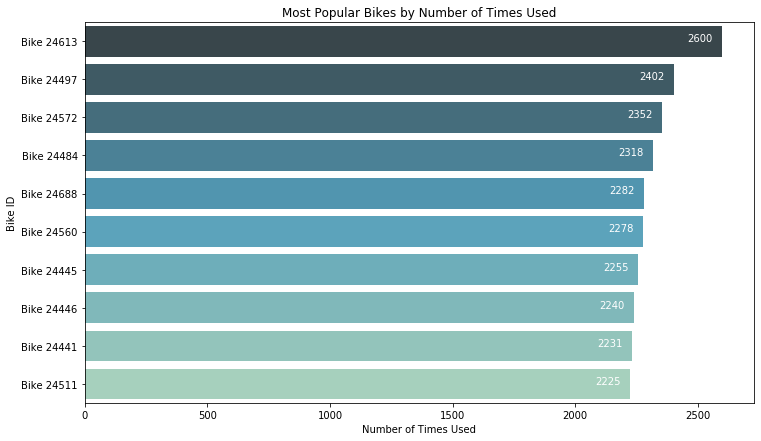

In [46]:
#Visual of most used bike based on Number of Trips
ax8 = sns.barplot('Number of Times Used', 'Bike ID',data = bike_use_df, palette="GnBu_d")
ax8.set_title('Most Popular Bikes by Number of Times Used')
for index, row in bike_use_df.iterrows():
    ax8.text(row['Number of Times Used']-90,index,row['Number of Times Used'], color='white', ha="center", fontsize =10)
plt.show()

In [47]:
#Bike usage based on minutes used
#del(ax8)
bike_min_df = pd.DataFrame()
bike_min_df['Minutes Used'] = df.groupby('Bike ID')['Minutes'].sum()
bike_min_df = bike_min_df.reset_index()
bike_min_df = bike_min_df.sort_values('Minutes Used', ascending = False)
bike_min_df['Bike ID'] = bike_min_df['Bike ID'].astype(str)
bike_min_df['Bike ID'] = ('Bike ' + bike_min_df['Bike ID'])
bike_min_df = bike_min_df[:10]
bike_min_df = bike_min_df.reset_index()
#bike_min_df.head()

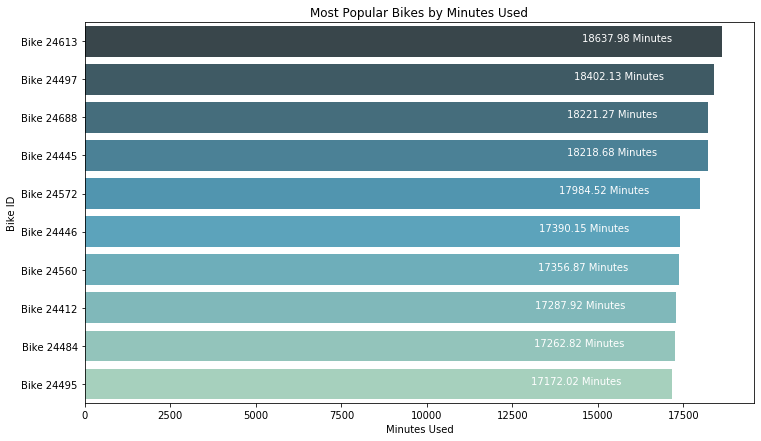

In [48]:
#Visual of most used bike based on number of minutes used
ax9 = sns.barplot('Minutes Used', 'Bike ID',data = bike_min_df, palette="GnBu_d")
ax9.set_title('Most Popular Bikes by Minutes Used')
rcParams['figure.figsize'] = 11,6
for index, row in bike_min_df.iterrows():
    ax9.text(row['Minutes Used']-2800,index,str(round(row['Minutes Used'],2))+' Minutes', 
             color='white', ha="center")
plt.show()

### Part 6.1: Predictive Model - Baseline Model
Ask: Build a model that can predict how long a trip will take given a starting 
     point and destination. 

***Assumptions on how the Kiosk will work:*** After speaking to Daniel Yawitz (if you're 
looking at this, thanks for the clarification), I was told that we should assume that when
a user inputs the start and end station, they swipe their key fob (if they're a subscriber)
and enter their info on the kiosk (if they're a "Customer") prior to entering the start 
and end station. This means that we would know their gender and age. Thus these variables
can be used in building the model.

Step 1.  
   - This dataset is massive. Almost 14 million rows. Let's work on a *random* subsample while we build and evaluate models. If I tried to build and evaluate a model on the entire dataset, each run would take me ~10+ minutes depending on the model. One good way to decide what portion of your data to work with is using a learning curve. However, my kernel keeps crashing while trying to create that learning curve. However, given the size of the data and from experience by working with senior data scientists on projects with BAML and other firms I know that I can comfortably work with a few thoushand rows of data given the fact that this is only one year of data. If we were working with data for multiple years, I'd need to reconsider this approach. However, given the reasons above, I've decided to sample 10% of the data. It's stil ~1.3 million rows and should be a representative sample since it's randomly selected. I'll be evaluating my model on df_sample.
  - I also made the same visuals on the sample to visualize the data.
          
          
Step 2. 
  - Let's get a baseline. If I were to just run a simple multi-variate linear regression, what would my model look like and how accurate would it be? Need to prepare the data for a multivariate regression
      1. Drop irrelevant columns
           - Trip Duration: We have the minutes column, which is the target variable
            - Stop Time: In the real world, we won't have this information when predicting the trip duration.
             - Start Station ID: Start Station Name captures this information
            - Start Station Latitude: Start Station Name captures this information
            - Start Station Longitude: Start Station Name captures this information
            - Start Coordinates: Start Station Name captures this information
            - End Station ID: End Station Name captures this information
           - End Station Latitude: End Station Name captures this information
            - End Station Longitude: End Station Name captures this information
            - End Coordinates: End Station Name captures this information
             - Bike Id: We won't know what bike the user is going to end up using
             - Min_Mile: Effectively the same information as end time when combined with distance. We won't have this information in the real world.
             - mile_hour: Effectively the same information as end time when combined with distance. We won't have this information in the real world.
                    (Speed * Distance = Trip Duration): Which is why speed is dropped
             - Birth Year: Age captures this information
             - Start Station Name and End Station Name: The distance variable captures the same information. For the model, if a user is inputting start and end station, we can build a simple function to calculate the distance which would capture the same information.
      2. Basic cleaning of data FOR NOW.This is only being done for the baseline model
          - Start Time: Requires reformatting. Will do this after baseline model
           - Dumify categorical variables
            - Scale Age
            - Don't scale distance, since it does not just represent distance, but is also indicative of the trip the rider is making (start and station)
      3. Anomalies in Trip Duration
          - I'm going to come back to an observation from earlier. Any trip which lasts longer than *45 minutes(2,700 seconds)* probably indicates a stolen bike, incorrect docking of the bike, or an anomaly. No rider would plan to go over the maximum 45 minutes allowed. Additionally, there are only ~200k rows where the trips last longer than 45 minutes. That is less than 1% of the data and can be considered anomalies. Even if we include it, the model won't be able to learn from it due to the small sample. Lastly, as an avid Citibike user, I know first hand that it doesn't make any sense for one to use a bike for more than 45 minutes! The only way a trip actually lasts more than 45 minutes is if a user couldn't find a dock at their desired station. 

- Age was removed after an initial run indicated it had no effect on the model. This was also clearly indicated in some of the visuals above. Reasons for not binning age are in section 6.3.

In [49]:
round(df.describe(),2)

,Trip Duration,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,Birth Year,Trip_Duration_in_min,Minutes,Distance,Age,min_mile,mile_hour
count,655111.00,655111.00,655111.00,655111.00,655111.00,655111.00,655111.00,655111.00,655111.00,655111.00,655111.00,655111.00,655111.00,655111.00,655111.00
mean,455.48,3206.99,40.72,-74.05,3203.33,40.72,-74.05,24919.97,1980.02,7.59,7.59,0.70,37.98,11.12,6.00
std,332.92,26.82,0.01,0.01,63.92,0.01,0.01,758.03,8.67,5.56,5.55,0.45,8.67,4.26,1.78
min,61.00,3183.00,40.69,-74.10,152.00,40.69,-74.10,14552.00,1956.00,1.00,1.02,0.09,18.00,3.62,1.81
25%,237.00,3186.00,40.72,-74.05,3186.00,40.72,-74.05,24486.00,1976.00,4.00,3.95,0.41,32.00,8.41,4.82
50%,354.00,3202.00,40.72,-74.04,3198.00,40.72,-74.04,24603.00,1982.00,6.00,5.90,0.56,36.00,10.06,5.96
75%,565.00,3211.00,40.73,-74.04,3211.00,40.73,-74.04,24712.00,1986.00,9.00,9.42,0.88,42.00,12.45,7.14
max,5985.00,3426.00,40.75,-74.03,3426.00,40.78,-73.96,29296.00,2000.00,100.00,99.75,5.26,62.00,33.24,16.58


### Observations
- We have some unreasonable speeds in min_mile column, but that's fine. Some people may have walked with their bike or stopped at multiple destinations before docking.
- The sample data below seems to be representative of the entire dataset above.

In [50]:
#Cleaning up anomalies
df = df.drop(df.index[(df['Trip Duration'] > 2700)])

In [51]:
#Let's work with a random sample of the data and inspect it thoroughly to ensure it's representative
df_sample = df.sample(frac = 0.1, random_state = 0)
#round(df_sample.describe(),2)

### Build a Baseline Model

In [52]:
df.head()
df2 = df.copy() 
#df = df.drop(['level_0', 'level_1'], axis = 1)

In [53]:
#Drop Irrelevant data
def drop_data(df):
    df = df.drop(['Trip Duration','Stop Time','Start Station ID','Start Station Latitude','Start Station Longitude',
                  'Start Coordinates','End Station ID', 'End Station Latitude', 'End Station Longitude', 
                  'End Coordinates','Bike ID', 'Start Station Name','Birth Year','End Station Name','min_mile',
                  'mile_hour','Age'], axis = 1)
    return df

df_basemodel = drop_data(df_sample)

In [54]:
df_basemodel = df_basemodel.drop('Start Time', axis =1)

In [55]:
#Dummify categorical data and avoid dummy variable trap
df_basemodel = pd.get_dummies(df_basemodel, drop_first = True)
#df_basemodel.dtypes

In [56]:
df_basemodel.corr().loc[:,'Minutes']

Trip_Duration_in_min    0.998603
Minutes                 1.000000
Distance                0.790130
User Type_Subscriber   -0.243266
Gender_1               -0.110553
Gender_2                0.002184
Name: Minutes, dtype: float64

In [57]:
#Train Test Split
#Predictor variable
X = df_basemodel.iloc[:,1:]
#Target variable
y = df_basemodel.iloc[:,0]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [58]:
#Fit Linear Regression and check accuracy using sklearn
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.997164986346871

In [59]:
#Using Statsmodel because it has the summary function.
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
regressor_OLS = sm.OLS(y_train, X_train).fit()
regressor_OLS.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Trip_Duration_in_min   R-squared:                       0.997
Model:                              OLS   Adj. R-squared:                  0.997
Method:                   Least Squares   F-statistic:                 3.757e+06
Date:                  Sun, 10 Nov 2019   Prob (F-statistic):               0.00
Time:                          01:45:29   Log-Likelihood:                -9302.2
No. Observations:                 52371   AIC:                         1.862e+04
Df Residuals:                     52365   BIC:                         1.867e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0057      0.007     -0.822      0.411      -0.019       0.008
Minutes                  1.0001      0.000   2535.337      0.000       0.999       1.001
Distance                 0.0007      0.005      0.145      0.885      -0.008       0.010
User Type_Subscriber     0.0077      0.012      0.661      0.508      -0.015       0.031
Gender_1                -0.0065      0.010     -0.651      0.515      -0.026       0.013
Gender_2              8.303e-05      0.010      0.008      0.994      -0.020       0.020
==============================================================================
Omnibus:                    47107.390   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3151.492
Skew:                           0.001   Prob(JB):                         0.00
Kurtosis:                       1.798   Cond. No.                         132.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Part 6.2: Predictive Model - Including Date 

**Baseline Model:** Adjusted R^2 and R^2 = 56.5% (depending on random_state)        
 1. The baseline model is ok, but nothing spectacular. The R_Squared and Adjusted R_Squared is 
    pretty much the same, 53.6%. The F-Stat is also 0.00 which is a good sign. The gender female's 
    p-value is high, however, we can't loose this information due to the fact that this is a categorical
    variable and we'd be loosing substantial information by dropping it. 
 2. Steps to make improvements:
    a) Add back time in the following format
      - Is the ride on a WEEKDAY or WEEKEND. Weekday, is rush-hour commute for the most part and
          probably from home to work. Weekend could be a longer, more casual ride and have higher variability.
      - Is the ride in the MORNING, AFTERNOON, EVENING, or NIGHT. The exact timing will be based on the 
          difference in trip duration based on time of day. Will have visuals below.
      - What season is it?
        - December - Feb. = Winter
        - March - May = Spring
        - June - Aug. = Summer
        - Sept. - Nov. = Fall
 3. Evaluate model and check correlation to ensure against collinearity and identify what's going on

In [60]:
#The following code was used to create get_date_info
'''
#Weekday or Weekend: 1 = Weekday, 0 = Weekend
df_model1['d_week'] = (df_model1['d_week']<5).astype(int)

#Season of the year: Winter = 0, Spring = 1, Summer = 2, Fall = 3
df_model1['m_yr'] = df_model1['m_yr'].replace(to_replace=[12,1,2], value = 0)
df_model1['m_yr'] = df_model1['m_yr'].replace(to_replace=[3,4,5], value = 1)
df_model1['m_yr'] = df_model1['m_yr'].replace(to_replace=[6,7,8], value = 2)
df_model1['m_yr'] = df_model1['m_yr'].replace(to_replace=[9,10,11], value = 3)

#Visualize difference in ridership based on time of day
#Ploted both mean and media, similar pattern, using median due to the high variance in the data
fig3, ax10 = plt.subplots(figsize=(15,7))
df_model1.groupby('ToD').mean()['Minutes'].plot(ax=ax10)
#df_model1.groupby('ToD').median()['Minutes'].plot(ax=ax10)
plt.ylabel('Median Minutes per Trip')
plt.xlabel('Hour of the Day')
plt.title('Median Minutes per Trip by Time of Day')
plt.show()

#Based on the visual above and distribution of ridership: NIGHT = 20-5, MORNING = 5-9, AFTERNON = 9-14, EVENING = 14-20
df_model1['ToD'] = pd.cut(df_model1['ToD'], bins=[-1, 5, 9, 14, 20, 25], labels=['Night','Morning','Afternoon','Evening','Night1'])
df_model1['ToD'] = df_model1['ToD'].replace(to_replace='Night1', value = 'Night')
df_model1['ToD'] = df_model1['ToD'].cat.remove_unused_categories()

#Convert m_yr to categorical
df_model1['m_yr'] = df_model1['m_yr'].astype('category')


#Dummify categorical data and avoid 
df_model1 = pd.get_dummies(df_model1, drop_first = True)
'''
def get_date_info(df):
    df['d_week'] = df['Start Time'].dt.dayofweek
    df['m_yr'] = df['Start Time'].dt.month
    df['ToD'] = df['Start Time'].dt.hour

    df['d_week'] = (df['d_week']<5).astype(int)

    df['m_yr'] = df['m_yr'].replace(to_replace=[12,1,2], value = 0)
    df['m_yr'] = df['m_yr'].replace(to_replace=[3,4,5], value = 1)
    df['m_yr'] = df['m_yr'].replace(to_replace=[6,7,8], value = 2)
    df['m_yr'] = df['m_yr'].replace(to_replace=[9,10,11], value = 3)
    
    df['ToD'] = pd.cut(df['ToD'], bins=[-1, 5, 9, 14, 20, 25], labels=['Night','Morning','Afternoon','Evening','Night1'])
    df['ToD'] = df['ToD'].replace(to_replace='Night1', value = 'Night')
    df['ToD'] = df['ToD'].cat.remove_unused_categories()
    
    df['m_yr'] = df['m_yr'].astype('category')
    df['d_week'] = df['d_week'].astype('category')

    return(df)
df_women2 = df.copy()
df


,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,...,Birth Year,Gender,Trip_Duration_in_min,Minutes,Start Coordinates,End Coordinates,Distance,Age,min_mile,mile_hour
0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,Christ Hospital,40.734786,-74.050444,3207,Oakland Ave,40.737604,...,1960.0,1,6,6.266667,"(40.734785818, -74.050443636)","(40.7376037, -74.05247829999998)",0.221838,58,28.25,2.12
3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,Newport Pkwy,40.728745,-74.032108,3187,Warren St,40.721124,...,1975.0,1,5,4.583333,"(40.7287448, -74.03210820000002)","(40.72112360000001, -74.03805095)",0.611454,43,7.50,8.00
4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,...,1984.0,0,9,9.350000,"(40.7162469, -74.0334588)","(40.7112423, -74.0557013)",1.217823,34,7.68,7.81
5,365,2015-10-01 00:41:46,2015-10-01 00:47:51,3198,Heights Elevator,40.748716,-74.040443,3215,Central Ave,40.746730,...,1984.0,0,6,6.083333,"(40.748715945380226, -74.04044330120088)","(40.7467299, -74.0492509)",0.482094,34,12.62,4.75
6,139,2015-10-01 00:43:44,2015-10-01 00:46:03,3206,Hilltop,40.731169,-74.057574,3195,Sip Ave,40.730743,...,1988.0,1,2,2.316667,"(40.7311689, -74.0575736)","(40.730742625306576, -74.06378388404845)",0.327309,30,7.08,8.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717653,239,2017-03-31 21:26:40,2017-03-31 21:30:39,3195,Sip Ave,40.730743,-74.063784,3201,Dey St,40.737711,...,1970.0,1,4,3.983333,"(40.730742625306576, -74.06378388404845)","(40.737711, -74.066921)",0.508248,48,7.84,7.66
717654,192,2017-03-31 21:46:57,2017-03-31 21:50:09,3183,Exchange Place,40.716247,-74.033459,3267,Morris Canal,40.712419,...,1976.0,1,3,3.200000,"(40.7162469, -74.0334588)","(40.7124188237569, -74.03852552175522)",0.374889,42,8.54,7.03
717655,186,2017-03-31 22:03:56,2017-03-31 22:07:02,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,...,1956.0,1,3,3.100000,"(40.7162469, -74.0334588)","(40.71277420000001, -74.03648570000001)",0.287536,62,10.78,5.57
717656,618,2017-03-31 23:20:14,2017-03-31 23:30:32,3272,Jersey & 3rd,40.723332,-74.045953,3268,Lafayette Park,40.713464,...,1984.0,1,10,10.300000,"(40.723331586464354, -74.04595255851744)","(40.71346382669195, -74.06285852193831)",1.118670,34,9.21,6.52


In [61]:
#Dataset for the second model
df_model1 = drop_data(df_sample)
df_model1 = get_date_info(df_model1)
df_model1 = df_model1.drop('Start Time', axis =1)
df_model1

,User Type,Gender,Trip_Duration_in_min,Minutes,Distance,d_week,m_yr,ToD
615711,Subscriber,1,3,2.516667,0.292686,1,3,Night
360706,Subscriber,1,5,4.750000,0.585072,1,1,Morning
509455,Subscriber,1,3,2.683333,0.287536,1,2,Morning
37055,Subscriber,2,4,4.000000,0.529657,0,3,Afternoon
251923,Subscriber,2,12,11.533333,1.100923,0,3,Afternoon
...,...,...,...,...,...,...,...,...
241289,Subscriber,1,8,7.650000,0.256328,1,3,Evening
654496,Subscriber,2,6,5.650000,0.376587,1,0,Evening
410536,Subscriber,1,16,15.550000,1.456659,0,0,Evening
550893,Subscriber,1,3,3.350000,0.298241,1,2,Morning


In [62]:
#Dummify categorical data and avoid dummy variable trap
df_model1 = pd.get_dummies(df_model1, drop_first = True)
#df_model1.dtypes

In [63]:
#Train Test Split
#Predictor variable
X = df_model1.iloc[:,1:]
#Target variable
y = df_model1.iloc[:,0]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [64]:
#Fit Linear Regression and check accuracy using sklearn
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.9971643529059063

In [65]:
#Using Statsmodel because it has the summary function.
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
regressor_OLS = sm.OLS(y_train, X_train).fit()
regressor_OLS.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Trip_Duration_in_min   R-squared:                       0.997
Model:                              OLS   Adj. R-squared:                  0.997
Method:                   Least Squares   F-statistic:                 1.565e+06
Date:                  Sun, 10 Nov 2019   Prob (F-statistic):               0.00
Time:                          01:45:30   Log-Likelihood:                -9294.6
No. Observations:                 52371   AIC:                         1.862e+04
Df Residuals:                     52358   BIC:                         1.873e+04
Df Model:                            12                                         
Covariance Type:              nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0038      0.008     -0.445      0.656      -0.020       0.013
Minutes                  1.0000      0.000   2492.197      0.000       0.999       1.001
Distance                 0.0021      0.005      0.442      0.658      -0.007       0.011
User Type_Subscriber     0.0098      0.012      0.834      0.404      -0.013       0.033
Gender_1                -0.0072      0.010     -0.727      0.467      -0.027       0.012
Gender_2                -0.0005      0.010     -0.044      0.965      -0.020       0.020
d_week_1                -0.0045      0.003     -1.360      0.174      -0.011       0.002
m_yr_1                   0.0083      0.004      2.081      0.037       0.000       0.016
m_yr_2                   0.0019      0.004      0.476      0.634      -0.006       0.010
m_yr_3                   0.0013      0.004      0.369      0.712      -0.006       0.008
ToD_Morning             -0.0063      0.005     -1.386      0.166      -0.015       0.003
ToD_Afternoon           -0.0045      0.005     -0.932      0.352      -0.014       0.005
ToD_Evening              0.0015      0.004      0.346      0.730      -0.007       0.010
==============================================================================
Omnibus:                    46875.349   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3148.728
Skew:                           0.001   Prob(JB):                         0.00
Kurtosis:                       1.799   Cond. No.                         133.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
df_model1.corr().loc[:,'Minutes']

Trip_Duration_in_min    0.998603
Minutes                 1.000000
Distance                0.790130
User Type_Subscriber   -0.243266
Gender_1               -0.110553
Gender_2                0.002184
d_week_1               -0.099507
m_yr_1                 -0.012380
m_yr_2                  0.078114
m_yr_3                  0.006514
ToD_Morning            -0.090699
ToD_Afternoon           0.071367
ToD_Evening             0.051769
Name: Minutes, dtype: float64

### Part 6.3: Predictive Model - Improving Model 1
Model 1: Negligible improvement in R^2: 67% (depending on random_state used)

   - Date seems to not have as big of an impact. May be more useful to split time and day differently, but
    acording to the graphs, there is no indication of a better split. Next steps will be to factor in speed
    and distance based on Gender and Trip. By not being able to encode start and end stations (due to the
    sheer number of points), we are losing crucial information on the trip itself. We need another proxy for
    those measures. 
   - Another change I could make is to bin age into buckets. However, the data indicates that age has no correlation
    or effect on the trip duration. This is counter-intuitive, however, I don't have a good reason to refute the data.

Next Steps:
 1. Include Average Speed based on: Trip and User Type
    - Reason for Trip: 
      - Some trips are up hill, others are down hill. Some routes, such as one through times square involve heavy trafic, based on intuition.
     - Reason for User Type: 
        - Tourists (Customers), will usually ride more slowly with frequent stops than a Subscriber, according to the data.
 2. Include average duration for each trip based on: Trip and User Type
    - Reason, for each, same as above.
      - Using seconds instead of minutes for granularity in information.

 3. A bit of inexperience here:
    - The imputed columns are "dependent" variables in the since speed is derived from trip duration and distance. 
      - There may be a better way to do this, however, I would need to consult someone. Would appreciate feedback on this.
      - I don't think it should be a big issue that they're "dependent" since they serve more as anchor points. But I'd appreciate feeback.

In [1]:
#Code below used to create get_speed_distance
'''
df_model2 = df_sample

df_model2['Start Station Name'] = df_model2['Start Station Name'].astype(str)
df_model2['End Station Name'] = df_model2['End Station Name'].astype(str)
df_model2['Trip'] = df_model2['Start Station Name'] + ' to ' + df_model2['End Station Name']
df_model2['Trip'] = df_model2['Trip'].astype('category')

df_model2['avg_speed'] = df_model2.groupby(['Trip','User Type'])['mile_hour'].transform('mean')
df_model2['avg_duration'] = df_model2.groupby(['Trip','User Type'])['Trip Duration'].transform('median')
#Code to make sure transfrom function works appropriately.
#df_model2[df_model2['avg_speed']==df_model2.loc[258881]['avg_speed']]
'''
def get_speed_distance(df):

    df['Start Station Name'] = df['Start Station Name'].astype(str)
    df['End Station Name'] = df['End Station Name'].astype(str)
    df['Trip'] = df['Start Station Name'] + ' to ' + df['End Station Name']
    df['Trip'] = df['Trip'].astype('category')
    
    df['avg_speed'] = df.groupby(['Trip','User Type'])['mile_hour'].transform('mean')
    df['avg_duration'] = df.groupby(['Trip','User Type'])['Trip Duration'].transform('median')
    
    return df

In [68]:
#Drop Irrelevant data, updated with Trip
def drop_data_trip(df):
    df = df.drop(['Trip Duration','Stop Time','Start Station ID','Start Station Latitude','Start Station Longitude',
                  'Start Coordinates','End Station ID', 'End Station Latitude', 'End Station Longitude', 
                  'End Coordinates','Bike ID', 'Start Station Name','Birth Year','End Station Name','min_mile', 
                  'mile_hour', 'Age', 'Trip'], axis = 1)
    return df

In [69]:
df_model2 = get_speed_distance(df_sample)
df_model2 = drop_data_trip(df_model2)
df_model2 = get_date_info(df_model2)
df_model2 = df_model2.drop('Start Time', axis =1)
df_model2=df_model2.dropna()

In [70]:
#Dummify categorical data and avoid dummy variable trap
df_model2 = pd.get_dummies(df_model2, drop_first = True)
#df_model2.dtypes

In [71]:
#Train Test Split
#Predictor variable
X = df_model2.iloc[:,1:]
#Target variable
y = df_model2.iloc[:,0]
#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [72]:
#Fit Linear Regression and check accuracy using sklearn
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.9973379568487214

In [73]:
#Using Statsmodel because it has the summary function.
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
regressor_OLS = sm.OLS(y_train, X_train).fit()
regressor_OLS.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Trip_Duration_in_min   R-squared:                       0.997
Model:                              OLS   Adj. R-squared:                  0.997
Method:                   Least Squares   F-statistic:                 8.430e+05
Date:                  Sun, 10 Nov 2019   Prob (F-statistic):               0.00
Time:                          01:45:30   Log-Likelihood:                -5602.6
No. Observations:                 31302   AIC:                         1.124e+04
Df Residuals:                     31287   BIC:                         1.136e+04
Df Model:                            14                                         
Covariance Type:              nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0037      0.013      0.279      0.780      -0.022       0.030
Minutes                  1.0005      0.000   2043.887      0.000       1.000       1.001
Distance                -0.0050      0.006     -0.868      0.385      -0.016       0.006
avg_speed               -0.0008      0.001     -0.701      0.484      -0.003       0.001
avg_duration         -1.214e-06   3.63e-06     -0.335      0.738   -8.32e-06    5.89e-06
User Type_Subscriber     0.0077      0.015      0.505      0.613      -0.022       0.038
Gender_1                -0.0071      0.013     -0.536      0.592      -0.033       0.019
Gender_2                -0.0043      0.013     -0.318      0.751      -0.031       0.022
d_week_1                 0.0018      0.004      0.431      0.666      -0.006       0.010
m_yr_1                   0.0063      0.005      1.205      0.228      -0.004       0.017
m_yr_2                   0.0007      0.005      0.140      0.889      -0.009       0.011
m_yr_3                   0.0022      0.005      0.487      0.626      -0.007       0.011
ToD_Morning             -0.0078      0.006     -1.300      0.194      -0.020       0.004
ToD_Afternoon           -0.0050      0.006     -0.791      0.429      -0.017       0.007
ToD_Evening             -0.0008      0.006     -0.143      0.886      -0.012       0.010
==============================================================================
Omnibus:                    28898.569   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1893.582
Skew:                          -0.008   Prob(JB):                         0.00
Kurtosis:                       1.795   Cond. No.                     1.28e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Part 6.4: Predictive Model - Improving Model 2 
Model 2 is VERY VERY good.

The model above is extremely good. But can I make it even better?

- One of the grading requirements for the project is to include an additional data source. Weather and traffic make the most sense. I could include pedestrian traffic data from citibike's website, however, I don't think it'll be too helpful due to the fact that there are now bikelanes in NYC. I could use weather data as well.
    - Concerns with using weather data:
        - Weather dictates whether or not a rider will bike, not how long they will bike. For weather to determine
        how long one will bike, it would have to dictate where they go. However, since grading deends on my ability
        to use external data, I'm going to test this hypothesis. If weather is not a strong indicatior, I will remove
        it in the next model. 

In [74]:
#Load and clean weather data from 2017 (Min Temp, Max Temp, Precipitation)
df_weather = pd.read_csv('Files/weather2017.csv')
df_weather = df_weather.iloc[:,1:5]
df_weather['DATE'] = to_datetime(df_weather['DATE'])

In [75]:
#Following code was used to create get_weather()
'''
df_model3['DATE'] = to_datetime(df_model3['Start Time'].dt.date)


df_w = df_weather
df_mod = df_model3    

df_w.head()
df_mod.dtypes
test = df_mod.merge(df_w, on = 'DATE', how = 'left')
test.head()

df = df_model3.merge(df_weather, on = 'DATE', how = 'left')
'''

def get_weather(df):
    df['DATE'] = to_datetime(df['Start Time'].dt.date)
    df = df.merge(df_weather, on = 'DATE', how = 'left')
    return df

In [76]:
#Create dataset to test the model on
df_model3 = get_speed_distance(df_sample)
df_model3 = drop_data(df_model3)
df_model3 = get_date_info(df_model3)
df_model3 = get_weather(df_model3)
df_model3 = df_model3.drop(['Start Time','Trip','DATE'], axis =1)
df_model3=df_model3.dropna()
df_model3

,User Type,Gender,Trip_Duration_in_min,Minutes,Distance,avg_speed,avg_duration,d_week,m_yr,ToD,PRCP,TMAX,TMIN
1,Subscriber,1,5,4.750000,0.585072,2.360000,326.0,1,1,Morning,0.72,46.0,41.0
5,Subscriber,1,19,19.316667,1.552934,4.257500,240.0,1,1,Night,0.00,39.0,24.0
30,Subscriber,1,17,16.783333,1.668429,5.013333,495.0,1,1,Morning,0.00,45.0,26.0
47,Subscriber,0,2,2.233333,0.253726,4.818333,1545.5,0,0,Evening,0.05,48.0,43.0
62,Subscriber,1,9,8.583333,0.966462,5.920000,1274.0,1,1,Evening,0.00,39.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65412,Subscriber,1,3,2.916667,0.416431,4.665000,1513.0,1,1,Night,0.00,42.0,23.0
65414,Subscriber,1,9,8.783333,0.694166,3.550000,653.0,1,1,Morning,0.72,46.0,41.0
65419,Subscriber,1,3,3.200000,0.423763,4.330000,480.0,1,0,Evening,0.00,49.0,39.0
65422,Subscriber,1,6,5.933333,0.759130,5.737500,670.0,1,1,Morning,0.00,64.0,35.0


In [77]:
#Dummify categorical data and avoid dummy variable trap
df_model3 = pd.get_dummies(df_model3, drop_first = True)

#Scale Continuous variables
from sklearn.preprocessing import StandardScaler
sc_m1 = StandardScaler()
df_model3['avg_duration'] = sc_m1.fit_transform(df_model3[['avg_duration']])
sc_m2 = StandardScaler()
df_model3['TMIN'] = sc_m2.fit_transform(df_model3[['TMIN']])
sc_m3 = StandardScaler()
df_model3['TMAX'] = sc_m3.fit_transform(df_model3[['TMAX']])
sc_m4 = StandardScaler()
df_model3['PRCP'] = sc_m4.fit_transform(df_model3[['PRCP']])
df_model3

,Trip_Duration_in_min,Minutes,Distance,avg_speed,avg_duration,PRCP,TMAX,TMIN,User Type_Subscriber,Gender_1,Gender_2,d_week_1,m_yr_1,m_yr_2,m_yr_3,ToD_Morning,ToD_Afternoon,ToD_Evening
1,5,4.750000,0.585072,2.360000,-0.996593,3.179858,-0.347221,0.597355,1,1,0,1,1,0,0,1,0,0
5,19,19.316667,1.552934,4.257500,-1.183341,-0.379517,-0.989728,-1.208809,1,1,0,1,1,0,0,0,0,0
30,17,16.783333,1.668429,5.013333,-0.629610,-0.379517,-0.439008,-0.996319,1,1,0,1,1,0,0,1,0,0
47,2,2.233333,0.253726,4.818333,1.651543,-0.132338,-0.163648,0.809845,1,0,0,0,0,0,0,0,0,1
62,9,8.583333,0.966462,5.920000,1.061983,-0.379517,-0.989728,-1.208809,1,1,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65412,3,2.916667,0.416431,4.665000,1.580970,-0.379517,-0.714368,-1.315054,1,1,0,1,1,0,0,0,0,0
65414,9,8.783333,0.694166,3.550000,-0.286514,3.179858,-0.347221,0.597355,1,1,0,1,1,0,0,1,0,0
65419,3,3.200000,0.423763,4.330000,-0.662183,-0.379517,-0.071861,0.384865,1,1,0,1,0,0,0,0,0,1
65422,6,5.933333,0.759130,5.737500,-0.249599,-0.379517,1.304939,-0.040115,1,1,0,1,1,0,0,1,0,0


In [78]:
#Train Test Split
#Predictor variable
X = df_model3.iloc[:,1:]
#Target variable
y = df_model3.iloc[:,0]
#Split
#from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [79]:
#Fit Linear Regression and check accuracy using sklearn
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.9954400797769715

In [80]:
#Using Statsmodel because it has the summary function.
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
regressor_OLS = sm.OLS(y_train, X_train).fit()
regressor_OLS.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Trip_Duration_in_min   R-squared:                       0.996
Model:                              OLS   Adj. R-squared:                  0.996
Method:                   Least Squares   F-statistic:                 7.241e+04
Date:                  Sun, 10 Nov 2019   Prob (F-statistic):               0.00
Time:                          01:45:30   Log-Likelihood:                -814.01
No. Observations:                  4636   AIC:                             1660.
Df Residuals:                      4620   BIC:                             1763.
Df Model:                            15                                         
Covariance Type:              nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0315      0.047      0.672      0.502      -0.060       0.123
Minutes                  0.9993      0.002    586.552      0.000       0.996       1.003
Distance                -0.0148      0.018     -0.824      0.410      -0.050       0.020
avg_speed               -0.0052      0.003     -1.780      0.075      -0.011       0.001
avg_duration            -0.0023      0.004     -0.523      0.601      -0.011       0.006
PRCP                     0.0026      0.004      0.578      0.563      -0.006       0.011
TMAX                    -0.0047      0.008     -0.561      0.575      -0.021       0.012
TMIN                     0.0113      0.008      1.381      0.167      -0.005       0.027
User Type_Subscriber    -0.0583      0.048     -1.214      0.225      -0.153       0.036
Gender_1                 0.0596      0.026      2.291      0.022       0.009       0.111
Gender_2                 0.0375      0.027      1.374      0.169      -0.016       0.091
d_week_1                 0.0015      0.012      0.126      0.900      -0.022       0.025
m_yr_1                   0.0102      0.009      1.116      0.265      -0.008       0.028
m_yr_2               -6.215e-19   2.94e-17     -0.021      0.983   -5.82e-17     5.7e-17
m_yr_3               -1.406e-18   2.97e-18     -0.473      0.636   -7.24e-18    4.42e-18
ToD_Morning             -0.0016      0.016     -0.099      0.921      -0.034       0.031
ToD_Afternoon            0.0063      0.018      0.355      0.722      -0.028       0.041
ToD_Evening              0.0064      0.016      0.407      0.684      -0.025       0.037
==============================================================================
Omnibus:                     3787.166   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.526
Skew:                           0.022   Prob(JB):                     8.98e-61
Kurtosis:                       1.804   Cond. No.                     2.53e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.45e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [81]:
#Ensure model accuracy with cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regressor, X_train, y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.996 +/- 0.000


- Removing unnecessary variables based on correlation: ToD, m_yr, PRCP, TMAX,TMIN

In [82]:
#Create dataset to test the model on
df_model4 = get_speed_distance(df_sample)
df_model4 = drop_data(df_model4)
df_model4 = get_date_info(df_model4)
df_model4 = get_weather(df_model4)
df_model4 = df_model4.drop(['Start Time','Trip','DATE','PRCP','TMAX','TMIN'], axis =1)

In [83]:
#Dummify categorical data and avoid dummy variable trap
df_model4 = pd.get_dummies(df_model4, drop_first = True)

#Scale Continuous variables
from sklearn.preprocessing import StandardScaler
sc_m1 = StandardScaler()
df_model4['avg_duration'] = sc_m1.fit_transform(df_model4[['avg_duration']])

In [84]:
#Train Test Split
#Predictor variable
df_model4=df_model4.replace([np.inf, -np.inf], np.nan)
df_model4=df_model4.dropna()
X = df_model4.iloc[:,1:]
#Target variable
y = df_model4.iloc[:,0]
#Split
#from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [85]:
#Fit Linear Regression and check accuracy using sklearn
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.9973379568487214

#### Assesing the viability of a different model such as RandomForest

In [86]:
#Ensemble algorithm, to see if there's a drastic difference, n_est. and min_samples_leaf determined after testing
from sklearn.ensemble import RandomForestRegressor

regressor_rf = RandomForestRegressor(n_estimators = 80, random_state = 0, min_samples_leaf = 600)
regressor_rf.fit(X_train,y_train)
regressor_rf.score(X_test,y_test)

0.9646421541294867

### Part 6.5: Predictive Model - Final Model
- As I thought, weather is not a major contributor to the model. Thus, I'll be taking out weather. Additionally, I'll be taking out date attributes as mentioned earlier. 
    1. The ensemble algorithm, Random Forest takes much longer to run (even with a low n_estimators). If the run
    time is 5 minutes on ~1.5 million rows, I don't want to take the risk on ~15 million rows of data. 
    2. I could've used XGboost and other fancy algorithms, however, for a dataset of this size, it would take too
    long to run and the gains wouldn't be worth it if there are any. 
    3. Final Model:
        - Linear Regression:
            - Predictors: Distance, Gender, Average Duration based on Trip and Gender, User Type

In [87]:
def prep_data(df):
    df = get_speed_distance(df)
    df = drop_data(df)
    df = get_date_info(df)
    df = df.drop(['Start Time','Trip','m_yr',], axis =1)
    return df

df_final = prep_data(df)

In [88]:
#Dummify categorical data and avoid dummy variable trap
df_final = pd.get_dummies(df_final, drop_first = True)

#Scale Continuous variables
from sklearn.preprocessing import StandardScaler
sc_m1 = StandardScaler()
df_final['avg_duration'] = sc_m1.fit_transform(df_final[['avg_duration']])
sc_m1 = StandardScaler()
df_final['avg_speed'] = sc_m1.fit_transform(df_final[['avg_speed']])

In [89]:
#Train Test Split
#Predictor variable
df_final=df_final.dropna()
X = df_final.iloc[:,1:]
#Target variable
y = df_final.iloc[:,0]
#Split
#from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#X_test=X_test.dropna()
#X_test
#X_train=X_train.dropna()
#X_train 
#y_train=y_train.dropna()
#y_train
#y_test=y_test.dropna()
#y_test

In [90]:
#Fit Linear Regression and check accuracy using sklearn
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.9971457785527679

My Work is Located at this Location (: 


In [91]:
df_final.head() 

,Trip_Duration_in_min,Minutes,Distance,avg_speed,avg_duration,User Type_Subscriber,Gender_1,Gender_2,d_week_1,ToD_Morning,ToD_Afternoon,ToD_Evening
0,6,6.266667,0.221838,-0.379213,0.771455,1,1,0,1,0,0,0
5,6,6.083333,0.482094,0.092689,1.712533,0,0,0,1,0,0,0
6,2,2.316667,0.327309,-0.307933,0.735680,1,1,0,1,0,0,0
8,11,10.783333,1.295671,0.441783,-1.206101,1,1,0,1,0,0,0
10,6,5.866667,0.467110,0.057576,-0.054349,0,0,0,1,0,0,0


In [92]:
#Train Test Split
#Predictor variable
X = df_final.loc[:,df_final.columns != 'Gender_1']
#Target variable
y = df_final.iloc[:,6]
#Split
#from sklearn.cross_validation import train_test_split
df_final=df_final.dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#X_test=X_test.dropna()
#X_test
#X_train=X_train.dropna()
#X_train 
#y_train=y_train.dropna()
#y_train
#y_test=y_test.dropna()
#y_test

In [93]:
#Fit Linear Regression and check accuracy using sklearn
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.915507047330862

In [94]:
y_pred = regressor.predict(X_test)
y_round = y_pred.round(decimals=0).astype(int) 
df_preddd = pandas.DataFrame({"Actual": y_test, "Predicted": y_pred, "Predicted_Rounded": y_round}) 
df_preddd.head()


,Actual,Predicted,Predicted_Rounded
570104,1,0.978777,1
266187,1,0.981780,1
225316,0,0.002709,0
388815,1,0.975131,1
353451,1,0.979788,1


In [95]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.915507047330862

THIS IS WOMEN POPULARITY SECTION 

In [96]:
df_women= pd.read_csv("Files/NYC-BikeShare-2015-2017-combined.csv")
#Ensure data is formatted correctly to avoid errors in the visuals
df_women['Start Time'] = to_datetime(df_women['Start Time'])
df_women['Stop Time'] = to_datetime(df_women['Stop Time'])
df_women['Start Station Name'] = df_women['Start Station Name'].astype('category')
df_women['End Station Name'] = df_women['End Station Name'].astype('category')
df_women['User Type'] = df_women['User Type'].astype('category')
df_women['Gender'] = df_women['Gender'].astype('category')
round(df.describe(),2)
df_women = df_women.drop(['Unnamed: 0'], axis = 1)
df_women.head()


,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Trip_Duration_in_min
0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,Christ Hospital,40.734786,-74.050444,3207,Oakland Ave,40.737604,-74.052478,24470,Subscriber,1960.0,1,6
1,739,2015-10-01 00:27:12,2015-10-01 00:39:32,3207,Oakland Ave,40.737604,-74.052478,3212,Christ Hospital,40.734786,-74.050444,24481,Subscriber,1960.0,1,12
2,2714,2015-10-01 00:32:46,2015-10-01 01:18:01,3193,Lincoln Park,40.724605,-74.078406,3193,Lincoln Park,40.724605,-74.078406,24628,Subscriber,1983.0,1,45
3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,Newport Pkwy,40.728745,-74.032108,3187,Warren St,40.721124,-74.038051,24613,Subscriber,1975.0,1,5
4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,-74.055701,24668,Customer,1984.0,0,9


In [97]:
df_women2


,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,...,Birth Year,Gender,Trip_Duration_in_min,Minutes,Start Coordinates,End Coordinates,Distance,Age,min_mile,mile_hour
0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,Christ Hospital,40.734786,-74.050444,3207,Oakland Ave,40.737604,...,1960.0,1,6,6.266667,"(40.734785818, -74.050443636)","(40.7376037, -74.05247829999998)",0.221838,58,28.25,2.12
3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,Newport Pkwy,40.728745,-74.032108,3187,Warren St,40.721124,...,1975.0,1,5,4.583333,"(40.7287448, -74.03210820000002)","(40.72112360000001, -74.03805095)",0.611454,43,7.50,8.00
4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,...,1984.0,0,9,9.350000,"(40.7162469, -74.0334588)","(40.7112423, -74.0557013)",1.217823,34,7.68,7.81
5,365,2015-10-01 00:41:46,2015-10-01 00:47:51,3198,Heights Elevator,40.748716,-74.040443,3215,Central Ave,40.746730,...,1984.0,0,6,6.083333,"(40.748715945380226, -74.04044330120088)","(40.7467299, -74.0492509)",0.482094,34,12.62,4.75
6,139,2015-10-01 00:43:44,2015-10-01 00:46:03,3206,Hilltop,40.731169,-74.057574,3195,Sip Ave,40.730743,...,1988.0,1,2,2.316667,"(40.7311689, -74.0575736)","(40.730742625306576, -74.06378388404845)",0.327309,30,7.08,8.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717653,239,2017-03-31 21:26:40,2017-03-31 21:30:39,3195,Sip Ave,40.730743,-74.063784,3201,Dey St,40.737711,...,1970.0,1,4,3.983333,"(40.730742625306576, -74.06378388404845)","(40.737711, -74.066921)",0.508248,48,7.84,7.66
717654,192,2017-03-31 21:46:57,2017-03-31 21:50:09,3183,Exchange Place,40.716247,-74.033459,3267,Morris Canal,40.712419,...,1976.0,1,3,3.200000,"(40.7162469, -74.0334588)","(40.7124188237569, -74.03852552175522)",0.374889,42,8.54,7.03
717655,186,2017-03-31 22:03:56,2017-03-31 22:07:02,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,...,1956.0,1,3,3.100000,"(40.7162469, -74.0334588)","(40.71277420000001, -74.03648570000001)",0.287536,62,10.78,5.57
717656,618,2017-03-31 23:20:14,2017-03-31 23:30:32,3272,Jersey & 3rd,40.723332,-74.045953,3268,Lafayette Park,40.713464,...,1984.0,1,10,10.300000,"(40.723331586464354, -74.04595255851744)","(40.71346382669195, -74.06285852193831)",1.118670,34,9.21,6.52


In [98]:
df_women = get_date_info(df_women)
df_women

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Trip_Duration_in_min,d_week,m_yr,ToD
0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,Christ Hospital,40.734786,-74.050444,3207,Oakland Ave,40.737604,-74.052478,24470,Subscriber,1960.0,1,6,1,3,Night
1,739,2015-10-01 00:27:12,2015-10-01 00:39:32,3207,Oakland Ave,40.737604,-74.052478,3212,Christ Hospital,40.734786,-74.050444,24481,Subscriber,1960.0,1,12,1,3,Night
2,2714,2015-10-01 00:32:46,2015-10-01 01:18:01,3193,Lincoln Park,40.724605,-74.078406,3193,Lincoln Park,40.724605,-74.078406,24628,Subscriber,1983.0,1,45,1,3,Night
3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,Newport Pkwy,40.728745,-74.032108,3187,Warren St,40.721124,-74.038051,24613,Subscriber,1975.0,1,5,1,3,Night
4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,-74.055701,24668,Customer,1984.0,0,9,1,3,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735497,239,2017-03-31 21:26:40,2017-03-31 21:30:39,3195,Sip Ave,40.730743,-74.063784,3201,Dey St,40.737711,-74.066921,29276,Subscriber,1970.0,1,4,1,1,Night
735498,192,2017-03-31 21:46:57,2017-03-31 21:50:09,3183,Exchange Place,40.716247,-74.033459,3267,Morris Canal,40.712419,-74.038526,26177,Subscriber,1976.0,1,3,1,1,Night
735499,186,2017-03-31 22:03:56,2017-03-31 22:07:02,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,-74.036486,26240,Subscriber,1956.0,1,3,1,1,Night
735500,618,2017-03-31 23:20:14,2017-03-31 23:30:32,3272,Jersey & 3rd,40.723332,-74.045953,3268,Lafayette Park,40.713464,-74.062859,24398,Subscriber,1984.0,1,10,1,1,Night


In [99]:
#Dummify categorical data and avoid dummy variable trap
df_women = pd.get_dummies(df_women, drop_first = True)
df_women
#df_model1.dtypes

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,...,User Type_Subscriber,Gender_1,Gender_2,d_week_1,m_yr_1,m_yr_2,m_yr_3,ToD_Morning,ToD_Afternoon,ToD_Evening
0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,40.734786,-74.050444,3207,40.737604,-74.052478,24470,...,1,1,0,1,0,0,1,0,0,0
1,739,2015-10-01 00:27:12,2015-10-01 00:39:32,3207,40.737604,-74.052478,3212,40.734786,-74.050444,24481,...,1,1,0,1,0,0,1,0,0,0
2,2714,2015-10-01 00:32:46,2015-10-01 01:18:01,3193,40.724605,-74.078406,3193,40.724605,-74.078406,24628,...,1,1,0,1,0,0,1,0,0,0
3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,40.728745,-74.032108,3187,40.721124,-74.038051,24613,...,1,1,0,1,0,0,1,0,0,0
4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,40.716247,-74.033459,3192,40.711242,-74.055701,24668,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735497,239,2017-03-31 21:26:40,2017-03-31 21:30:39,3195,40.730743,-74.063784,3201,40.737711,-74.066921,29276,...,1,1,0,1,1,0,0,0,0,0
735498,192,2017-03-31 21:46:57,2017-03-31 21:50:09,3183,40.716247,-74.033459,3267,40.712419,-74.038526,26177,...,1,1,0,1,1,0,0,0,0,0
735499,186,2017-03-31 22:03:56,2017-03-31 22:07:02,3183,40.716247,-74.033459,3214,40.712774,-74.036486,26240,...,1,1,0,1,1,0,0,0,0,0
735500,618,2017-03-31 23:20:14,2017-03-31 23:30:32,3272,40.723332,-74.045953,3268,40.713464,-74.062859,24398,...,1,1,0,1,1,0,0,0,0,0


In [100]:
#Train Test Split
#Predictor variable
X = df_women.loc[:,['ToD_Morning', 'ToD_Afternoon', 'ToD_Evening', 'Start Station ID']] 
#Target variable
y = df_women.loc[:,"Gender_1"]
#Split
#from sklearn.cross_validation import train_test_split
df_women=df_women.dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#X_test=X_test.dropna()
#X_test
#X_train=X_train.dropna()
#X_train 
#y_train=y_train.dropna()
#y_train
#y_test=y_test.dropna()
#y_test

In [101]:
print(df_women.loc[:,['Start Station ID']])

        Start Station ID
0                   3212
1                   3207
2                   3193
3                   3199
4                   3183
...                  ...
735497              3195
735498              3183
735499              3183
735500              3272
735501              3185

[735502 rows x 1 columns]


In [102]:
#Fit Linear Regression and check accuracy using sklearn
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.005487625233618232

In [103]:
y_pred = regressor.predict(X_test)
#y_round = y_pred.round(decimals=0).astype(int) 
df_preddd2 = pandas.DataFrame({"Actual": y_test, "Predicted": y_pred}) 
df_preddd2.head()

,Actual,Predicted
186315,0,0.666568
611388,1,0.720856
634502,1,0.712678
728901,0,0.665825
285966,0,0.746617


In [104]:
#Fit Linear Regression and check accuracy using sklearn
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.005487625233618232

In [105]:
pop_df = df2.copy()   
# pd.read_csv("Files/NYC-BikeShare-2015-2017-combined.csv")
#Ensure data is formatted correctly to avoid errors in the visuals
pop_df['Start Station Name'] = pop_df['Start Station Name'].astype(str)

''' 
pop_df['Start Time'] = to_datetime(df_women['Start Time'])
pop_df['Stop Time'] = to_datetime(df_women['Stop Time'])
pop_df['Start Station Name'] = pop_df['Start Station Name'].astype('category')
pop_df['End Station Name'] = pop_df['End Station Name'].astype('category')
pop_df['User Type'] = pop_df['User Type'].astype('category')
pop_df['Gender'] = pop_df['Gender'].astype('category')
pop_df = pop_df.drop(['Unnamed: 0'], axis = 1)
round(pop_df.describe(),2)
pop_df = pop_df.drop(pop_df.index[(pop_df['Trip Duration'] < 90) & 
                          (pop_df['Start Station Latitude'] == pop_df['End Station Latitude'])])
pop_df = pop_df.drop(pop_df.index[(pop_df['Trip Duration'] > 7200)])
pop_df = pop_df.drop(pop_df.index[(pop_df['Birth Year'] < 1956)])
pop_df['Birth Year'] = pop_df.groupby(['Gender','Start Station ID'])['Birth Year'].transform(lambda x: x.fillna(x.median()))
pop_df = pop_df.dropna(subset=['Birth Year'])
pop_df['Age'] = 2018 - pop_df['Birth Year']
pop_df['Age'] = pop_df['Age'].astype(int)
pop_df = pop_df.drop(pop_df.index[(pop_df['Distance'] == 0)])
'''
pop_df.head()


,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,...,Birth Year,Gender,Trip_Duration_in_min,Minutes,Start Coordinates,End Coordinates,Distance,Age,min_mile,mile_hour
0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,Christ Hospital,40.734786,-74.050444,3207,Oakland Ave,40.737604,...,1960.0,1,6,6.266667,"(40.734785818, -74.050443636)","(40.7376037, -74.05247829999998)",0.221838,58,28.25,2.12
3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,Newport Pkwy,40.728745,-74.032108,3187,Warren St,40.721124,...,1975.0,1,5,4.583333,"(40.7287448, -74.03210820000002)","(40.72112360000001, -74.03805095)",0.611454,43,7.50,8.00
4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,...,1984.0,0,9,9.350000,"(40.7162469, -74.0334588)","(40.7112423, -74.0557013)",1.217823,34,7.68,7.81
5,365,2015-10-01 00:41:46,2015-10-01 00:47:51,3198,Heights Elevator,40.748716,-74.040443,3215,Central Ave,40.746730,...,1984.0,0,6,6.083333,"(40.748715945380226, -74.04044330120088)","(40.7467299, -74.0492509)",0.482094,34,12.62,4.75
6,139,2015-10-01 00:43:44,2015-10-01 00:46:03,3206,Hilltop,40.731169,-74.057574,3195,Sip Ave,40.730743,...,1988.0,1,2,2.316667,"(40.7311689, -74.0575736)","(40.730742625306576, -74.06378388404845)",0.327309,30,7.08,8.48


In [106]:
#Gets date without categorizing 
def get_date_info2(df):   
    df['d_week'] = df['Start Time'].dt.dayofweek
    df['m_yr'] = df['Start Time'].dt.month
    df['ToD'] = df['Start Time'].dt.hour
    
    df['m_yr'] = df['m_yr'].astype('category')
    df['d_week'] = df['d_week'].astype('category')

    return(df)

In [107]:
pop_df = get_date_info2(pop_df)
pop_df

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,...,Minutes,Start Coordinates,End Coordinates,Distance,Age,min_mile,mile_hour,d_week,m_yr,ToD
0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,Christ Hospital,40.734786,-74.050444,3207,Oakland Ave,40.737604,...,6.266667,"(40.734785818, -74.050443636)","(40.7376037, -74.05247829999998)",0.221838,58,28.25,2.12,3,10,0
3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,Newport Pkwy,40.728745,-74.032108,3187,Warren St,40.721124,...,4.583333,"(40.7287448, -74.03210820000002)","(40.72112360000001, -74.03805095)",0.611454,43,7.50,8.00,3,10,0
4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,...,9.350000,"(40.7162469, -74.0334588)","(40.7112423, -74.0557013)",1.217823,34,7.68,7.81,3,10,0
5,365,2015-10-01 00:41:46,2015-10-01 00:47:51,3198,Heights Elevator,40.748716,-74.040443,3215,Central Ave,40.746730,...,6.083333,"(40.748715945380226, -74.04044330120088)","(40.7467299, -74.0492509)",0.482094,34,12.62,4.75,3,10,0
6,139,2015-10-01 00:43:44,2015-10-01 00:46:03,3206,Hilltop,40.731169,-74.057574,3195,Sip Ave,40.730743,...,2.316667,"(40.7311689, -74.0575736)","(40.730742625306576, -74.06378388404845)",0.327309,30,7.08,8.48,3,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717653,239,2017-03-31 21:26:40,2017-03-31 21:30:39,3195,Sip Ave,40.730743,-74.063784,3201,Dey St,40.737711,...,3.983333,"(40.730742625306576, -74.06378388404845)","(40.737711, -74.066921)",0.508248,48,7.84,7.66,4,3,21
717654,192,2017-03-31 21:46:57,2017-03-31 21:50:09,3183,Exchange Place,40.716247,-74.033459,3267,Morris Canal,40.712419,...,3.200000,"(40.7162469, -74.0334588)","(40.7124188237569, -74.03852552175522)",0.374889,42,8.54,7.03,4,3,21
717655,186,2017-03-31 22:03:56,2017-03-31 22:07:02,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,...,3.100000,"(40.7162469, -74.0334588)","(40.71277420000001, -74.03648570000001)",0.287536,62,10.78,5.57,4,3,22
717656,618,2017-03-31 23:20:14,2017-03-31 23:30:32,3272,Jersey & 3rd,40.723332,-74.045953,3268,Lafayette Park,40.713464,...,10.300000,"(40.723331586464354, -74.04595255851744)","(40.71346382669195, -74.06285852193831)",1.118670,34,9.21,6.52,4,3,23


In [108]:
pop_df = pop_df.rename(columns={"Start Station ID": "Start_ID"})
pop_df = pop_df.rename(columns={"Start Station Name": "Start_Name"})
pop_df

,Trip Duration,Start Time,Stop Time,Start_ID,Start_Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,...,Minutes,Start Coordinates,End Coordinates,Distance,Age,min_mile,mile_hour,d_week,m_yr,ToD
0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,Christ Hospital,40.734786,-74.050444,3207,Oakland Ave,40.737604,...,6.266667,"(40.734785818, -74.050443636)","(40.7376037, -74.05247829999998)",0.221838,58,28.25,2.12,3,10,0
3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,Newport Pkwy,40.728745,-74.032108,3187,Warren St,40.721124,...,4.583333,"(40.7287448, -74.03210820000002)","(40.72112360000001, -74.03805095)",0.611454,43,7.50,8.00,3,10,0
4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,...,9.350000,"(40.7162469, -74.0334588)","(40.7112423, -74.0557013)",1.217823,34,7.68,7.81,3,10,0
5,365,2015-10-01 00:41:46,2015-10-01 00:47:51,3198,Heights Elevator,40.748716,-74.040443,3215,Central Ave,40.746730,...,6.083333,"(40.748715945380226, -74.04044330120088)","(40.7467299, -74.0492509)",0.482094,34,12.62,4.75,3,10,0
6,139,2015-10-01 00:43:44,2015-10-01 00:46:03,3206,Hilltop,40.731169,-74.057574,3195,Sip Ave,40.730743,...,2.316667,"(40.7311689, -74.0575736)","(40.730742625306576, -74.06378388404845)",0.327309,30,7.08,8.48,3,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717653,239,2017-03-31 21:26:40,2017-03-31 21:30:39,3195,Sip Ave,40.730743,-74.063784,3201,Dey St,40.737711,...,3.983333,"(40.730742625306576, -74.06378388404845)","(40.737711, -74.066921)",0.508248,48,7.84,7.66,4,3,21
717654,192,2017-03-31 21:46:57,2017-03-31 21:50:09,3183,Exchange Place,40.716247,-74.033459,3267,Morris Canal,40.712419,...,3.200000,"(40.7162469, -74.0334588)","(40.7124188237569, -74.03852552175522)",0.374889,42,8.54,7.03,4,3,21
717655,186,2017-03-31 22:03:56,2017-03-31 22:07:02,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,...,3.100000,"(40.7162469, -74.0334588)","(40.71277420000001, -74.03648570000001)",0.287536,62,10.78,5.57,4,3,22
717656,618,2017-03-31 23:20:14,2017-03-31 23:30:32,3272,Jersey & 3rd,40.723332,-74.045953,3268,Lafayette Park,40.713464,...,10.300000,"(40.723331586464354, -74.04595255851744)","(40.71346382669195, -74.06285852193831)",1.118670,34,9.21,6.52,4,3,23


In [109]:
#Identify the 10 most popular trips
pop_df_2=pop_df
final_station=pop_df_2.groupby(['Start_ID', 'Start_Name']).size().reset_index(name = 'Count') 
final_station=final_station.drop(["Count"], axis=1)
final_station=final_station.set_index('Start_ID')
final_station

,Start_Name
Start_ID,
3183,Exchange Place
3184,Paulus Hook
3185,City Hall
3186,Grove St PATH
3187,Warren St
3188,NJCU
3189,West Side Light Rail
3190,Garfield Ave Station
3191,Union St


In [110]:
#Identify the 10 most popular trips
pop_df_2=pop_df
pop_df_2= pop_df_2.groupby(['d_week','m_yr', 'ToD']).Start_ID.apply(lambda x : x.mode()[0]).reset_index(name = 'Popular_id')
#pop_df_2['Popular_id'] = pop_df_2['Popular_id'].astype('int')
pop_df_2.head()
#trips_df.head()

,d_week,m_yr,ToD,Popular_id
0,0,1,0,3186.0
1,0,1,1,3211.0
2,0,1,2,3185.0
3,0,1,3,NaN
4,0,1,4,3183.0


In [111]:
final_station.get_value(3183,'Start_Name')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


'Exchange Place'

In [112]:
pop_df_2.head()

,d_week,m_yr,ToD,Popular_id
0,0,1,0,3186.0
1,0,1,1,3211.0
2,0,1,2,3185.0
3,0,1,3,NaN
4,0,1,4,3183.0


In [113]:
pop_df_2=pop_df_2.dropna()

In [114]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
pop_df_2 = pop_df_2.apply(le.fit_transform)

In [115]:
pop_df_2

,d_week,m_yr,ToD,Popular_id
0,0,0,0,3
1,0,0,1,21
2,0,0,2,2
4,0,0,4,0
5,0,0,5,18
...,...,...,...,...
2011,6,11,19,3
2012,6,11,20,3
2013,6,11,21,3
2014,6,11,22,3


In [116]:
X = pop_df_2.iloc[:,0:3]
y = pop_df_2.iloc[:,3]

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [118]:
X_train

,d_week,m_yr,ToD
984,3,5,0
522,1,9,18
1976,6,10,8
361,1,3,1
1825,6,4,1
...,...,...,...
839,2,10,23
1221,4,2,21
1658,5,9,2
560,1,11,8


In [119]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print(classifier.score(X_test,y_test))


#clf.predict_proba(X[:2, :]) 

0.36476426799007444


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [120]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(11, 16), random_state=1)
clf.fit(X_train, y_train) 

print(X_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)
#print(predict_test)

from sklearn.metrics import classification_report,confusion_matrix
#print(confusion_matrix(y_train,predict_train))
#print(classification_report(y_train,predict_train))

#print(confusion_matrix(y_test,predict_test))
print(classification_report(y_test,predict_test))

      d_week  m_yr  ToD
984        3     5    0
522        1     9   18
1976       6    10    8
361        1     3    1
1825       6     4    1
...      ...   ...  ...
839        2    10   23
1221       4     2   21
1658       5     9    2
560        1    11    8
688        2     4   16

[1608 rows x 3 columns]
              precision    recall  f1-score   support

           0       0.22      0.05      0.08        42
           1       0.00      0.00      0.00         3
           2       0.23      0.21      0.22        14
           3       0.60      0.97      0.74       152
           4       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         9
          10       0.39      0.19      0.26        36
          11       0.00      0.00      0.00         1
          13       0.00      0.00     

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [121]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_tran = scaler.transform(X_test)

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [122]:
y_pred_tran = classifier.predict(X_test_tran)
print(classification_report(y_test, y_pred_tran))

              precision    recall  f1-score   support

           0       0.28      0.31      0.30        42
           1       0.00      0.00      0.00         3
           2       0.15      0.14      0.15        14
           3       0.66      0.79      0.72       152
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         1
           9       0.20      0.11      0.14         9
          10       0.17      0.11      0.14        36
          11       0.00      0.00      0.00         1
          13       0.33      0.12      0.18         8
          14       0.14      0.08      0.11        12
          15       0.58      0.75      0.65        48
          17       0.00      0.00      0.00         1
          18       0.22      0.25      0.24         8
          19       0.38    

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [123]:
ypred_inverse = le.inverse_transform(predict_test)
ypred_inverse 

array([3186., 3195., 3186., 3267., 3186., 3203., 3186., 3186., 3267.,
       3203., 3186., 3186., 3203., 3186., 3186., 3186., 3186., 3186.,
       3186., 3186., 3217., 3186., 3185., 3186., 3203., 3186., 3186.,
       3186., 3186., 3186., 3209., 3183., 3186., 3186., 3203., 3186.,
       3186., 3203., 3186., 3186., 3186., 3186., 3203., 3185., 3186.,
       3186., 3186., 3186., 3203., 3195., 3186., 3185., 3203., 3186.,
       3186., 3186., 3186., 3203., 3186., 3186., 3195., 3186., 3186.,
       3186., 3186., 3203., 3186., 3186., 3186., 3186., 3186., 3186.,
       3214., 3195., 3183., 3186., 3185., 3211., 3186., 3209., 3185.,
       3186., 3186., 3203., 3186., 3186., 3186., 3195., 3195., 3186.,
       3186., 3203., 3186., 3207., 3186., 3185., 3186., 3217., 3186.,
       3186., 3186., 3183., 3186., 3186., 3203., 3186., 3186., 3203.,
       3207., 3186., 3186., 3186., 3203., 3203., 3186., 3186., 3203.,
       3186., 3203., 3203., 3186., 3186., 3186., 3207., 3186., 3209.,
       3186., 3186.,

In [124]:
ytest_inverse = le.inverse_transform(y_test)
ytest_inverse 

array([3186., 3183., 3195., 3209., 3202., 3203., 3186., 3186., 3190.,
       3194., 3207., 3186., 3199., 3186., 3186., 3186., 3186., 3183.,
       3183., 3186., 3217., 3183., 3185., 3186., 3187., 3186., 3186.,
       3186., 3186., 3186., 3207., 3183., 3186., 3186., 3267., 3186.,
       3186., 3203., 3186., 3186., 3186., 3186., 3202., 3185., 3186.,
       3195., 3195., 3186., 3203., 3195., 3186., 3186., 3203., 3186.,
       3202., 3186., 3186., 3186., 3186., 3186., 3195., 3185., 3186.,
       3186., 3213., 3214., 3186., 3183., 3186., 3185., 3186., 3187.,
       3211., 3185., 3186., 3186., 3211., 3195., 3202., 3192., 3213.,
       3183., 3186., 3203., 3183., 3186., 3186., 3183., 3183., 3186.,
       3186., 3194., 3185., 3207., 3183., 3194., 3186., 3199., 3185.,
       3186., 3186., 3206., 3186., 3186., 3203., 3186., 3186., 3203.,
       3207., 3207., 3186., 3183., 3213., 3203., 3195., 3186., 3209.,
       3186., 3184., 3202., 3183., 3186., 3186., 3225., 3186., 3209.,
       3186., 3186.,

In [125]:
final_station
ypred_inverse_final = []

for i in ypred_inverse: 
    ypred_inverse_final.append(final_station.get_value(i,'Start_Name'))
    
ypred_inverse_final

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


['Grove St PATH',
 'Sip Ave',
 'Grove St PATH',
 'Morris Canal',
 'Grove St PATH',
 'Hamilton Park',
 'Grove St PATH',
 'Grove St PATH',
 'Morris Canal',
 'Hamilton Park',
 'Grove St PATH',
 'Grove St PATH',
 'Hamilton Park',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Bayside Park',
 'Grove St PATH',
 'City Hall',
 'Grove St PATH',
 'Hamilton Park',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Brunswick St',
 'Exchange Place',
 'Grove St PATH',
 'Grove St PATH',
 'Hamilton Park',
 'Grove St PATH',
 'Grove St PATH',
 'Hamilton Park',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Hamilton Park',
 'City Hall',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Hamilton Park',
 'Sip Ave',
 'Grove St PATH',
 'City Hall',
 'Hamilton Park',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 

In [126]:
final_station
ytest_inverse_final = []

for i in ytest_inverse: 
    ytest_inverse_final.append(final_station.get_value(i,'Start_Name'))
    
ytest_inverse_final

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


['Grove St PATH',
 'Exchange Place',
 'Sip Ave',
 'Brunswick St',
 'Newport PATH',
 'Hamilton Park',
 'Grove St PATH',
 'Grove St PATH',
 'Garfield Ave Station',
 'McGinley Square',
 'Oakland Ave',
 'Grove St PATH',
 'Newport Pkwy',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Exchange Place',
 'Exchange Place',
 'Grove St PATH',
 'Bayside Park',
 'Exchange Place',
 'City Hall',
 'Grove St PATH',
 'Warren St',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Oakland Ave',
 'Exchange Place',
 'Grove St PATH',
 'Grove St PATH',
 'Morris Canal',
 'Grove St PATH',
 'Grove St PATH',
 'Hamilton Park',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Newport PATH',
 'City Hall',
 'Grove St PATH',
 'Sip Ave',
 'Sip Ave',
 'Grove St PATH',
 'Hamilton Park',
 'Sip Ave',
 'Grove St PATH',
 'Grove St PATH',
 'Hamilton Park',
 'Grove St PATH',
 'Newport PATH',
 'Grove St PATH',
 'Grove St PATH',
 'Grove

In [127]:
df_ypred = X_test.copy()
df_ypred['y_pred'] = ypred_inverse_final
df_ypred = df_ypred.reset_index()
df_ypred = df_ypred.drop('index',axis=1)
df_ypred

,d_week,m_yr,ToD,y_pred
0,0,9,14,Grove St PATH
1,4,3,1,Sip Ave
2,6,3,23,Grove St PATH
3,1,6,5,Morris Canal
4,2,10,13,Grove St PATH
...,...,...,...,...
398,2,9,5,Oakland Ave
399,4,3,16,Grove St PATH
400,1,0,11,Hamilton Park
401,0,2,5,Hamilton Park


In [128]:
#df_ytest = pd.DataFrame({"col1":X_test[:, 0], "col2":X_test[:,1], "col3":X_test[:,2]})
df_ytest = pd.DataFrame(X_test)
df_ytest['y_test'] = ytest_inverse_final
df_ytest = df_ytest.reset_index()
df_ytest = df_ytest.drop('index',axis=1)
df_ytest

,d_week,m_yr,ToD,y_test
0,0,9,14,Grove St PATH
1,4,3,1,Exchange Place
2,6,3,23,Sip Ave
3,1,6,5,Brunswick St
4,2,10,13,Newport PATH
...,...,...,...,...
398,2,9,5,Oakland Ave
399,4,3,16,Exchange Place
400,1,0,11,Hamilton Park
401,0,2,5,Essex Light Rail


In [132]:
from IPython.display import HTML
import base64

def create_download_link( df, title = "Download CSV file", filename = "data_ytest.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(df_ypred)


In [133]:
create_download_link(df_ytest)


In [131]:
#Ensure model accuracy with cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regressor, X_train, y_train, cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.169 +/- 0.039
